In [1]:
import pandas as pd
import seaborn as sns
sns.set(font_scale=1)
#sns.set_style("darkgrid")
#sns.set_context("poster")
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
%matplotlib inline
import sys
import os
from scipy.optimize import newton, minimize, fsolve
import numpy as np
import copy
import re
from numpy.polynomial.polynomial import polyfit

import matplotlib.patches
import matplotlib.ticker as mticker
import matplotlib.colors as mcolors
palette = list(mcolors.TABLEAU_COLORS.keys())
palette.extend(['salmon', 'teal','yellowgreen'])

In [2]:
sns.set_style("whitegrid", {
 'axes.spines.bottom': True,
 'axes.spines.left': True,
 'axes.spines.right': False,
 'axes.spines.top': False
})
sns.set_style("ticks")
sns.set_context("talk", font_scale=0.9)
cmap = sns.color_palette()

In [3]:
# CAA was reconstituted in 400uL instead of 500uL
# CAA peak will then be 5/4 times what it should be
## RR will then be 4/5 of what it should be
# Correction factor: 5/4

def RR2Asp(RR):
    return(54.611* ((RR * 5/4)**1.0578))
def RR2Asn(RR):
    return(60.033* ((RR * 5/4)**0.9177))

In [4]:
### Read measurements

annotation_df = pd.read_excel('annotation_df.xlsx')

### Replace all N/F with 0 before start ###
esheet_dict_mes = pd.read_excel('Met-Asp-levels_trim.xlsx', sheet_name=None)

metab_dict_mes = dict()
metab_names_mes = list()
for k in esheet_dict_mes.keys():
    if 'U-13C' not in k:
        metab_names_mes.append(k)
        metab_dict_mes[k] = copy.deepcopy(esheet_dict_mes[k]).rename(columns={'Area': 'Response'}).fillna(0)
        # If internal standard use response ratio:
        if sum(metab_dict_mes[k]['Response Ratio']) != 0:
            metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response Ratio']
        metab_dict_mes[k]['Sample_name'] = [fn.split('_')[-1] for fn in metab_dict_mes[k]['Filename']]
        
        # Add annotations:
        metab_dict_mes[k] = metab_dict_mes[k].merge(annotation_df, left_on='Sample_name', right_on='Sample_name')
        metab_dict_mes[k]['Response'] = metab_dict_mes[k]['Response'] / metab_dict_mes[k]['Dilution_factor']
        metab_dict_mes[k] = metab_dict_mes[k].drop(['Type', 'Filename', 'ISTD Response', 'Flag Details'], axis=1)

In [5]:
metab_names_mes

['Metformin pos',
 'Aspartate neg',
 'Asparagine pos',
 'NAD pos',
 'NADH pos',
 'AMP pos',
 'GMP pos',
 'IMP pos',
 'Argininosuccinate neg',
 'Carbamoylaspartate neg',
 'Citrulline pos',
 'Fumarate neg',
 'Glutathione disulfide pos',
 'Glutathione pos',
 'Glycerol 3-phosphate neg',
 'DHAP neg',
 'alpha-Ketoglutarate neg',
 'Glutamate neg',
 'Hypoxanthine pos',
 'Malate neg',
 'NADH_RR pos',
 'NAD_RR pos',
 'Ornithine pos',
 'Succinate neg',
 'UMP neg',
 'Uridine neg',
 'CMP neg']

In [6]:
df = copy.deepcopy(metab_dict_mes[metab_names_mes[0]]).drop(['Compound', 'RT', 'Formula', 'Response', 'Response Ratio'], axis=1)
for nam in metab_names_mes:
    assert(metab_dict_mes[nam]['Sample_name'].equals(df['Sample_name']))
    df[nam] = metab_dict_mes[nam]['Response']
    
    if 'Aspartate' in nam:
        df['Aspartate conc'] = RR2Asp(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['Dilution_factor'].values
    elif 'Asparagine' in nam:
        df['Asparagine conc'] = RR2Asn(metab_dict_mes[nam]['Response Ratio'].values) / metab_dict_mes[nam]['Dilution_factor'].values

In [7]:
df['NAD-NADH'] = (df['NAD pos'] / df['NADH pos']).replace(np.inf, np.nan)
# NAD/NADH ratio based on response ratio of each molecule
df['NAD-NADH_RR'] = (df['NAD_RR pos'] / df['NADH_RR pos']).replace(np.inf, np.nan)
df['IMP-AMP'] = (df['IMP pos'] / df['AMP pos']).replace(np.inf, np.nan)
df['GSH-GSSG'] = (df['Glutathione pos'] / df['Glutathione disulfide pos']).replace(np.inf, np.nan)
df['G3P-DHAP'] = (df['Glycerol 3-phosphate neg'] / df['DHAP neg']).replace(np.inf, np.nan)
df['ArgSuc-Citr'] = (df['Argininosuccinate neg'] / df['Citrulline pos']).replace(np.inf, np.nan)
df['Asp-Mal-aKG-Glu'] = ((df['Aspartate neg'] / df['Malate neg']) * (df['alpha-Ketoglutarate neg'] / df['Glutamate neg'])).replace(np.inf, np.nan)


#df['Aspartate conc'] = RR2Asp(df['Aspartate neg'].values) / df['Dilution_factor'].values
#df['Asparagine conc'] = RR2Asn(df['Asparagine pos'].values) / df['Dilution_factor'].values

In [8]:
df_mean = df.groupby(['Metformin', 'Treatment', 'Cell_line']).mean(numeric_only=True).reset_index()
df_stdev = df.groupby(['Metformin', 'Treatment', 'Cell_line']).std(numeric_only=True).reset_index()

In [9]:
mask = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14) & (df_mean['Treatment'] == 'Sal. mix')
df_mean.loc[mask, ['Proliferation_rate', 'Aspartate conc']]

,Proliferation_rate,Aspartate conc
2,1.062244,6972.389920
9,0.969543,3017.192331
15,0.788496,1394.418767
17,0.592586,445.566170
19,0.498832,365.628376


In [10]:
def sig_fit(x, top, midpoint, bottom, slope):
    return(top + (bottom - top) / (1 + (x / midpoint)**slope))

def x_XX(top, midpoint, bottom, slope, XX):
    #print(midpoint)
    #print(slope)
    yXX = (top - bottom)*(100-XX)/100 + bottom
    mid = (midpoint * ((top - yXX) / (yXX - bottom))**(1.0 / slope))
    return(mid)

def sig_fit_loss(mes_y, x, top, bottom, p):
    pred_y = sig_fit(x, top, p[0], bottom, p[1])
    return(sum((mes_y-pred_y)**2))

def fit_sigmoid(x, y , percentiles, Ngrid, top, bottom):
    bnds = ((1e-4, None), (1e-1, 1e4))
    def fun_sig_fit(p): return(sig_fit_loss(y, x, top, bottom, p))
    p_sig_fit = minimize(fun_sig_fit, (500, 1), method='L-BFGS-B', bounds=bnds)
    midpoint, slope = p_sig_fit.x
    # print(slope)
    # print(p_sig_fit.fun)

    x_lower = x_XX(top, midpoint, bottom, slope, percentiles[0])
    x_upper = x_XX(top, midpoint, bottom, slope, percentiles[1])
    x_sig = np.logspace(np.log10(x_lower), np.log10(x_upper), Ngrid, base=10)
    y_sig = sig_fit(x_sig, top, midpoint, bottom, slope)
    x50 = x_XX(top, midpoint, bottom, slope, 50)
    
    return(x_sig, y_sig, x50)

def plot_sigmoid(df_mean, ax1, top, mask, bottom=0, col='Aspartate conc', \
                 percentile=(1, 99), plt_mid=False, color='gray'):

    x = df[mask][col].values
    y = df[mask]['Proliferation_rate'].values
    
    x_sig, y_sig, x50 = fit_sigmoid(x, y, percentile, 1000, top, bottom)
    ax1.plot(x_sig, y_sig, '--', linewidth=3, color=color)
    
    print(x50)
    if plt_mid:
        ax1.vlines(x50, bottom, top, ls='--', color='r')
        halfmax = round(x50)
        anno_str = 'Asp half-max\n{} μM'.format(halfmax)
        props = dict(boxstyle='round', alpha=1, \
                     ec=(1., 0.5, 0.5), \
                     fc=(1., 0.8, 0.8), \
                     )
        if percentile[1] < 96:
            ax1.text(0.55, 0.4, anno_str, transform=ax1.transAxes, fontsize=10,
                     va="top", multialignment='center', \
                     bbox=props)
        else:
            ax1.text(0.55, 0.4, anno_str, transform=ax1.transAxes, fontsize=10,
                     va="top", multialignment='center', \
                     bbox=props)
    return(x_sig, y_sig, x50, bottom, top)

386.5657239461975
394.155416384375


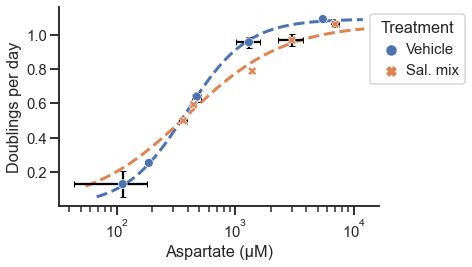

In [11]:
### Proliferation rate as a function of Aspartate ###

col='Aspartate conc'
order = ['Vehicle', 'Sal. mix']


fig = plt.figure(figsize=(6.8, 4))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.scatterplot(data=df_mean[mask1], x=col, y='Proliferation_rate', hue='Treatment',
             style='Treatment', markers=True, zorder=11, s=80, hue_order=order, style_order=order)
g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1][col].values, xerr=df_stdev[mask1][col].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=3, zorder=10)

g.set(xscale="log");
#g.set(xlim=(60, 10000))
#g.set(ylim=(0, 1.18))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)


plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);


top_i = [99.7, 97.45]
bottom_i = [5, 11]
for ci, sal_tr in enumerate(order):
    mask1 = (df_mean['Cell_line'] == 'H1299') & (df_mean['Metformin'] < 14) & \
            (df_mean['Treatment'] == sal_tr)
    top = df_mean[mask1]['Proliferation_rate'].max()
    mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14) & (df['Treatment'] == sal_tr)
    x_sig, y_sig, x50, bottom, top = plot_sigmoid(df_mean, g, top, mask, col=col, \
                                                  percentile=(bottom_i[ci], top_i[ci]), color=cmap[ci])


sns.despine()


plt.legend(bbox_to_anchor=(0.95, 1), loc="upper left", title='Treatment', handletextpad=0)#, fontsize=15, title_fontsize=15)
plt.tight_layout()

fig.savefig('H1299_Met_Asp_vs_prlfr.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)


382.52064531763244


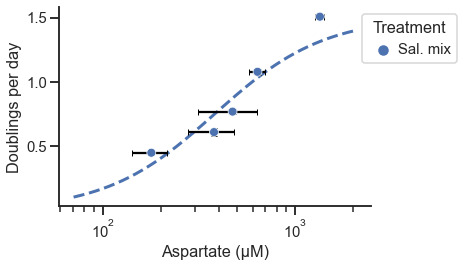

In [12]:
### Proliferation rate as a function of Aspartate ###

col='Aspartate conc'
order = ['Sal. mix']


fig = plt.figure(figsize=(6.8, 4))
mask1 = (df_mean['Cell_line']=='143B') & (df_mean['Metformin'] < 1.3) & (df_mean['Treatment'].isin(order))
g = sns.scatterplot(data=df_mean[mask1], x=col, y='Proliferation_rate', hue='Treatment',
             style='Treatment', markers=True, zorder=11, s=80, hue_order=order, style_order=order)
g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1][col].values, xerr=df_stdev[mask1][col].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=3, zorder=10)

g.set(xscale="log");
#g.set(xlim=(60, 10000))
#g.set(ylim=(0, 1.18))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)


plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);


top_i = [93]
bottom_i = [7]
for ci, sal_tr in enumerate(order):
    mask1 = (df_mean['Cell_line'] == '143B') & (df_mean['Metformin'] < 1.3) & \
            (df_mean['Treatment'] == sal_tr)
    top = df_mean[mask1]['Proliferation_rate'].max()
    mask = (df['Cell_line']=='143B') & (df['Metformin'] < 1.3) & (df['Treatment'] == sal_tr)
    x_sig, y_sig, x50, bottom, top = plot_sigmoid(df_mean, g, top, mask, col=col, \
                                                  percentile=(bottom_i[ci], top_i[ci]), color=cmap[ci])


sns.despine()


plt.legend(bbox_to_anchor=(0.95, 1), loc="upper left", title='Treatment', handletextpad=0)#, fontsize=15, title_fontsize=15)
plt.tight_layout()

fig.savefig('143B_Met_Asp_vs_prlfr.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)


27.02390096431261
14.099021781764549


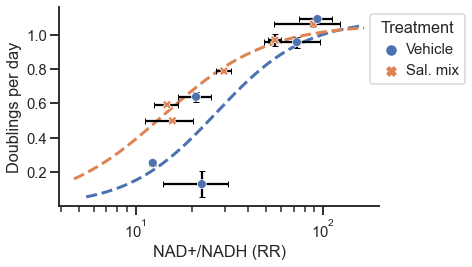

In [13]:
### Proliferation rate as a function of Aspartate ###

col='NAD-NADH_RR'
order = ['Vehicle', 'Sal. mix']


fig = plt.figure(figsize=(6.8, 4))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.scatterplot(data=df_mean[mask1], x=col, y='Proliferation_rate', hue='Treatment',
             style='Treatment', markers=True, zorder=11, s=80, hue_order=order, style_order=order)
g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1][col].values, xerr=df_stdev[mask1][col].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=3, zorder=10)

g.set(xscale="log");
#g.set(xlim=(60, 10000))
#g.set(ylim=(0, 1.18))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)


plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('NAD+/NADH (RR)')#, size=12);


top_i = [96.5, 98]
bottom_i = [5, 15]
for ci, sal_tr in enumerate(order):
    mask1 = (df_mean['Cell_line'] == 'H1299') & (df_mean['Metformin'] < 14) & \
            (df_mean['Treatment'] == sal_tr)
    top = df_mean[mask1]['Proliferation_rate'].max()
    mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14) & (df['Treatment'] == sal_tr)
    x_sig, y_sig, x50, bottom, top = plot_sigmoid(df_mean, g, top, mask, col=col, \
                                                  percentile=(bottom_i[ci], top_i[ci]), color=cmap[ci])


sns.despine()


plt.legend(bbox_to_anchor=(0.95, 1), loc="upper left", title='Treatment', handletextpad=0)#, fontsize=15, title_fontsize=15)
plt.tight_layout()

fig.savefig('H1299_Met_NAD_vs_prlfr.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)


In [29]:
def sig_fit_rv(x, top, midpoint, bottom, slope):
    return(bottom + (top - bottom) / (1 + (x / midpoint)**slope))

def x_XX_rv(top, midpoint, bottom, slope, XX):
    #print(midpoint)
    #print(slope)
    yXX = (top - bottom)*(100-XX)/100 + bottom
    mid = (midpoint * ((bottom - yXX) / (yXX - top))**(1.0 / slope))

    return(mid)

def sig_fit_loss_rv(mes_y, x, top, bottom, p):
    pred_y = sig_fit_rv(x, top, p[0], bottom, p[1])
    return(sum((mes_y-pred_y)**2))

def fit_sigmoid_rv(x, y , percentiles, Ngrid, top, bottom):
    bnds = ((1e-4, None), (1e-1, 1e4))
    def fun_sig_fit_rv(p): return(sig_fit_loss_rv(y, x, top, bottom, p))
    p_sig_fit = minimize(fun_sig_fit_rv, (1, 1), method='L-BFGS-B', bounds=bnds)
    midpoint, slope = p_sig_fit.x
    # print(slope)
    # print(p_sig_fit.fun)

    x_lower = x_XX_rv(top, midpoint, bottom, slope, percentiles[0])
    x_upper = x_XX_rv(top, midpoint, bottom, slope, percentiles[1])
    x_sig = np.logspace(np.log10(x_lower), np.log10(x_upper), Ngrid, base=10)
    y_sig = sig_fit_rv(x_sig, top, midpoint, bottom, slope)
    x50 = x_XX_rv(top, midpoint, bottom, slope, 50)
    
    return(x_sig, y_sig, x50)

def plot_sigmoid_rv(df_mean, ax1, top, mask, bottom=0, col='Aspartate conc', \
                 percentile=(1, 99), plt_mid=False, color='gray'):

    x = df[mask][col].values
    y = df[mask]['Proliferation_rate'].values
    
    x_sig, y_sig, x50 = fit_sigmoid_rv(x, y, percentile, 1000, top, bottom)
    ax1.plot(x_sig, y_sig, '--', linewidth=3, color=color)
    
    print(x50)
    if plt_mid:
        ax1.vlines(x50, bottom, top, ls='--', color='r')
        halfmax = round(x50)
        anno_str = 'Asp half-max\n{} μM'.format(halfmax)
        props = dict(boxstyle='round', alpha=1, \
                     ec=(1., 0.5, 0.5), \
                     fc=(1., 0.8, 0.8), \
                     )
        if percentile[1] < 96:
            ax1.text(0.55, 0.4, anno_str, transform=ax1.transAxes, fontsize=10,
                     va="top", multialignment='center', \
                     bbox=props)
        else:
            ax1.text(0.55, 0.4, anno_str, transform=ax1.transAxes, fontsize=10,
                     va="top", multialignment='center', \
                     bbox=props)
    return(x_sig, y_sig, x50, bottom, top)

2.3827860792585747
6.050453206025988


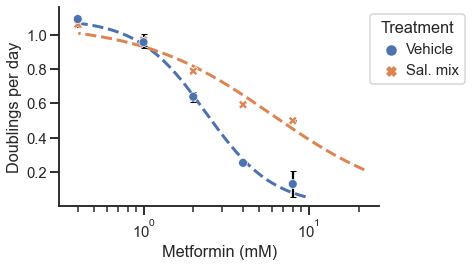

In [36]:
### Proliferation rate as a function of Aspartate ###

col='Metformin'
order = ['Vehicle', 'Sal. mix']


fig = plt.figure(figsize=(6.8, 4))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.scatterplot(data=df_mean[mask1], x=col, y='Proliferation_rate', hue='Treatment',
             style='Treatment', markers=True, zorder=11, s=80, hue_order=order, style_order=order)
g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1][col].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=3, zorder=10)

g.set(xscale="log");
#g.set(xlim=(60, 10000))
#g.set(ylim=(0, 1.18))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)


plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('Metformin (mM)')#, size=12);


top_i = [98, 95]
bottom_i = [5, 20]
for ci, sal_tr in enumerate(order):
    mask1 = (df_mean['Cell_line'] == 'H1299') & (df_mean['Metformin'] < 14) & \
            (df_mean['Treatment'] == sal_tr)
    top = df_mean[mask1]['Proliferation_rate'].max()
    mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14) & (df['Treatment'] == sal_tr)
    x_sig, y_sig, x50, bottom, top = plot_sigmoid_rv(df_mean, g, top, mask, col=col, \
                                                  percentile=(bottom_i[ci], top_i[ci]), color=cmap[ci])


sns.despine()


plt.legend(bbox_to_anchor=(0.95, 1), loc="upper left", title='Treatment', handletextpad=0)#, fontsize=15, title_fontsize=15)
plt.tight_layout()

fig.savefig('H1299_Met_Met_vs_prlfr.pdf', bbox_inches='tight')
plt.show(fig)
plt.close(fig)


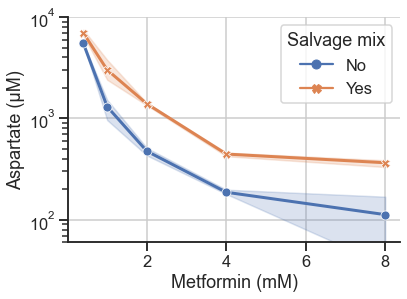

In [285]:
### Aspartate as a function of Metformin ###

pdf = matplotlib.backends.backend_pdf.PdfPages("metformin_vs_Asp_H1299_log.pdf")
fig = plt.figure(figsize=(6, 4.5))

mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.lineplot(data=df[mask], x='Metformin', y='Aspartate conc', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False, linewidth=3)
g.set(yscale="log");

plt.xlabel('Metformin (mM)')#, size=12);
plt.ylabel('Aspartate (μM)')#, size=12);
plt.legend(title='Salvage mix')

g.set(ylim=(60, 10000))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5, axis='y')
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(True)
sns.despine()



plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

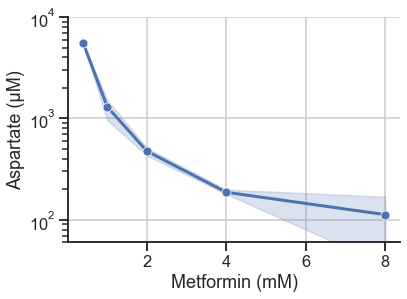

In [15]:
### Aspartate as a function of Metformin ###

pdf = matplotlib.backends.backend_pdf.PdfPages("metformin_vs_Asp_H1299_log_nosal.pdf")
fig = plt.figure(figsize=(6, 4.5))

mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14) & (df['Salvage_mix'] == 'No')
g = sns.lineplot(data=df[mask], x='Metformin', y='Aspartate conc', markers=True, linewidth=3, style='Salvage_mix')
g.set(yscale="log");

plt.xlabel('Metformin (mM)')#, size=12);
plt.ylabel('Aspartate (μM)')#, size=12);
g.get_legend().remove()

g.set(ylim=(60, 10000))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5, axis='y')
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(True)
sns.despine()



plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

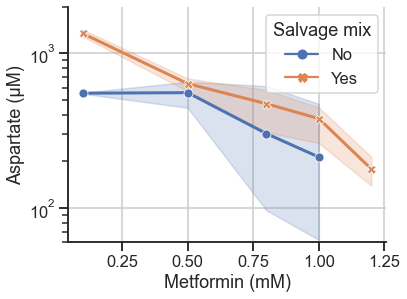

In [302]:
### Aspartate as a function of Metformin ###

pdf = matplotlib.backends.backend_pdf.PdfPages("metformin_vs_Asp_143B_log.pdf")
fig = plt.figure(figsize=(6, 4.5))


mask = (df['Cell_line']=='143B') & \
       (((df['Metformin'] < 1.3) & (df['Salvage_mix'] == 'Yes')) | \
        ((df['Metformin'] < 1.1) & (df['Salvage_mix'] == 'No')))
g = sns.lineplot(data=df[mask], x='Metformin', y='Aspartate conc', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False, linewidth=3)
g.set(yscale="log");

plt.xlabel('Metformin (mM)')#, size=12);
plt.ylabel('Aspartate (μM)')#, size=12);
plt.legend(title='Salvage mix')

g.set(ylim=(60, 2000))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5, axis='y')
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(True)
sns.despine()



plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

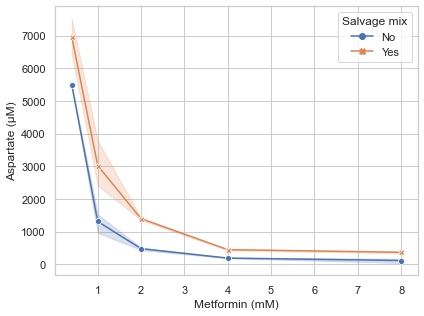

In [27]:
### Aspartate as a function of Metformin ###

pdf = matplotlib.backends.backend_pdf.PdfPages("metformin_vs_Asp_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))

mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.lineplot(data=df[mask], x='Metformin', y='Aspartate conc', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

plt.xlabel('Metformin (mM)', size=12);
plt.ylabel('Aspartate (μM)', size=12);
plt.legend(title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

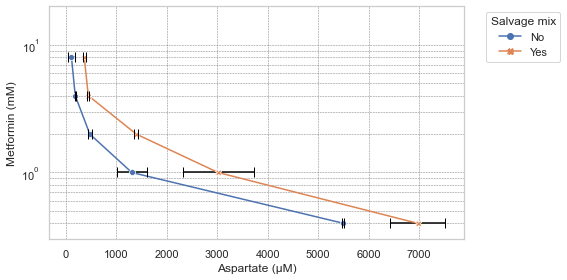

In [51]:
### Metformin as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Met_H1299_ylog.pdf")
fig = plt.figure(figsize=(8, 4))
mask = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask], x='Aspartate conc', y='Metformin', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)
g.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5)
g.set(yscale="log");


plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
g.yaxis.set_minor_locator(locmin)
g.yaxis.set_minor_formatter(mticker.NullFormatter())
g.set(ylim=(0.3, 20))


plt.ylabel('Metformin (mM)', size=12);
plt.xlabel('Aspartate (μM)', size=12);

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

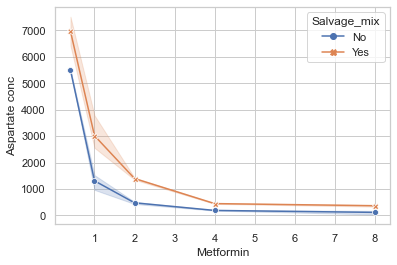

In [88]:
### Subtract confidence interval ###

mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.lineplot(data=df[mask], x='Metformin', y='Aspartate conc', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

c1 = g.collections[0].get_paths()[0].vertices
c2 = g.collections[1].get_paths()[0].vertices


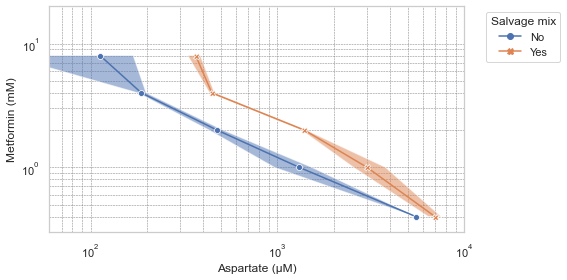

In [98]:
### Metformin as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Met_H1299_dlog.pdf")
fig = plt.figure(figsize=(8, 4))
mask = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask], x='Aspartate conc', y='Metformin', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)
#g.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5)
g.set(yscale="log");
g.set(xscale="log");


plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
g.yaxis.set_minor_locator(locmin)
g.yaxis.set_minor_formatter(mticker.NullFormatter())
g.set(ylim=(0.3, 20))
g.set(xlim=(60, 10000))


g.fill_between(c1[:,1], c1[:,0], alpha=0.5)
g.fill_between(c2[:,1], c2[:,0], alpha=0.5)



plt.ylabel('Metformin (mM)', size=12);
plt.xlabel('Aspartate (μM)', size=12);

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

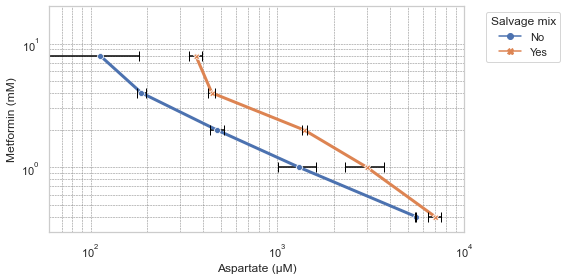

In [157]:
### Metformin as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Met_H1299_dlog_err.pdf")
fig = plt.figure(figsize=(8, 4))
mask = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask], x='Aspartate conc', y='Metformin', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False, linewidth=3)
g.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5)
g.set(yscale="log");
g.set(xscale="log");


plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
g.yaxis.set_minor_locator(locmin)
g.yaxis.set_minor_formatter(mticker.NullFormatter())
g.set(ylim=(0.3, 20))
g.set(xlim=(60, 10000))


plt.ylabel('Metformin (mM)', size=12);
plt.xlabel('Aspartate (μM)', size=12);

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

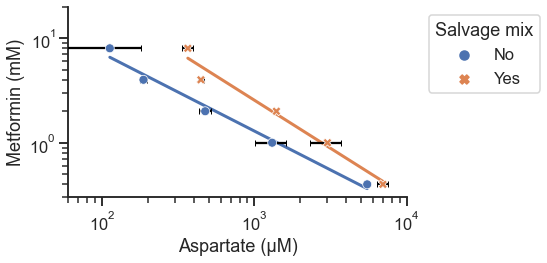

In [9]:
### Metformin as a function of Aspartate ###
pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Met_H1299_dlog_err_reg.pdf")
fig = plt.figure(figsize=(8, 4))
mask = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.scatterplot(data=df_mean[mask], x='Aspartate conc', y='Metformin', hue='Salvage_mix',
             style='Salvage_mix', markers=True, zorder=11, s=80)
g.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3, zorder=10)
g.set(yscale="log");
g.set(xscale="log");

g.set(ylim=(0.3, 20))
g.set(xlim=(60, 10000))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)
    

plt.ylabel('Metformin (mM)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);


if True:
    ### Fit regression ###
    x_no = np.array([np.log10(x) for x, b in zip(df_mean[mask]['Aspartate conc'], df_mean[mask]['Salvage_mix']) if b == 'No' ])
    y_no = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'No' ])

    x_yes = np.array([np.log10(x) for x, b in zip(df_mean[mask]['Aspartate conc'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])
    y_yes = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])

    b_no, m_no = polyfit(x_no, y_no, 1)
    b_yes, m_yes = polyfit(x_yes, y_yes, 1)

    plt.plot(10**x_no, 10**(b_no + m_no * x_no), '-', linewidth=3)
    plt.plot(10**x_yes, 10**(b_yes + m_yes * x_yes), '-', linewidth=3)

    ######################

sns.despine()
    

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

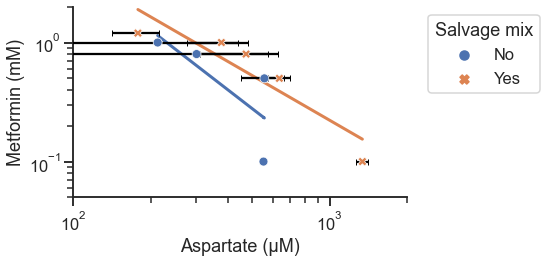

In [491]:
### Metformin as a function of Aspartate ###
pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Met_143B_dlog_err_reg.pdf")
fig = plt.figure(figsize=(8, 4))
mask = (df_mean['Cell_line']=='143B') & \
       (((df_mean['Metformin'] < 1.3) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 1.1) & (df_mean['Salvage_mix'] == 'No')))
g = sns.scatterplot(data=df_mean[mask], x='Aspartate conc', y='Metformin', hue='Salvage_mix',
             style='Salvage_mix', markers=True, zorder=11, s=80)
g.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3, zorder=10)
g.set(yscale="log");
g.set(xscale="log");

g.set(ylim=(0.05, 2))
g.set(xlim=(100, 2000))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)
    

plt.ylabel('Metformin (mM)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);


if True:
    ### Fit regression ###
    x_no = np.array([np.log10(x) for x, b in zip(df_mean[mask]['Aspartate conc'], df_mean[mask]['Salvage_mix']) if b == 'No' ])
    y_no = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'No' ])

    x_yes = np.array([np.log10(x) for x, b in zip(df_mean[mask]['Aspartate conc'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])
    y_yes = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])

    b_no, m_no = polyfit(x_no, y_no, 1)
    b_yes, m_yes = polyfit(x_yes, y_yes, 1)

    plt.plot(10**x_no, 10**(b_no + m_no * x_no), '-', linewidth=3)
    plt.plot(10**x_yes, 10**(b_yes + m_yes * x_yes), '-', linewidth=3)

    ######################

sns.despine()
    

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

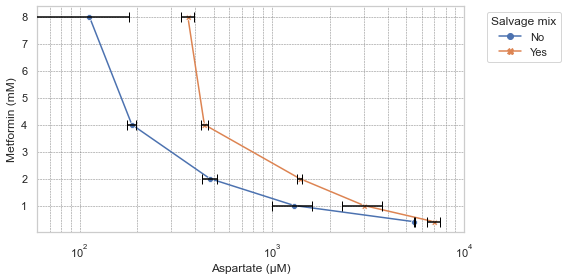

In [215]:
### Metformin as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Met_H1299_xlog.pdf")
fig = plt.figure(figsize=(8, 4))
mask = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask], x='Aspartate conc', y='Metformin', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)
g.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5, zorder=10)
#g.set(yscale="log");
g.set(xscale="log");


plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
g.xaxis.set_minor_locator(locmin)
g.xaxis.set_minor_formatter(mticker.NullFormatter())
g.set(xlim=(60, 10000))


plt.ylabel('Metformin (mM)', size=12);
plt.xlabel('Aspartate (μM)', size=12);

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

In [ ]:
# prof_max/(1+Q*exp(-B*[asp])**(1/v)

<ipython-input-11-a07d64e48f5a>:12: RuntimeWarning: divide by zero encountered in double_scalars
  return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))
<ipython-input-11-a07d64e48f5a>:12: RuntimeWarning: overflow encountered in power
  return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


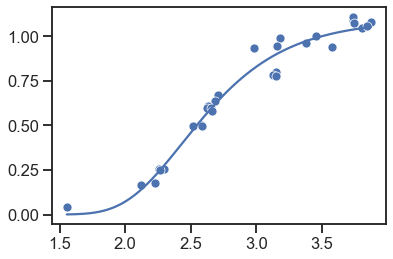

In [11]:
### Generate sigmoid fit for proliferation data ###

mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
prof_max = df_mean[mask1]['Proliferation_rate'].max()

mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
x = np.array([np.log10(x) for x in df[mask]['Aspartate conc']])
y = np.array([y for y in df[mask]['Proliferation_rate']])


def sig_fit(asp_conc, prof_max, Q, B, v):
    return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))

def sig_fit_loss(mes_prof, asp_conc, prof_max, p):
    pred_prof = sig_fit(asp_conc, prof_max, p[0], p[1], p[2])
    return(sum((mes_prof-pred_prof)**2))

bnds = ((0, None), (0, None), (0, None))
def fun_sig_fit(p): return(sig_fit_loss(y, x, prof_max, p))
p_sig_fit = minimize(fun_sig_fit, (1, 1, 1), method='L-BFGS-B', bounds=bnds)

sns.scatterplot(x, y)
x_sig = np.arange(min(x), max(x), 0.01)
plt.plot(x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]))

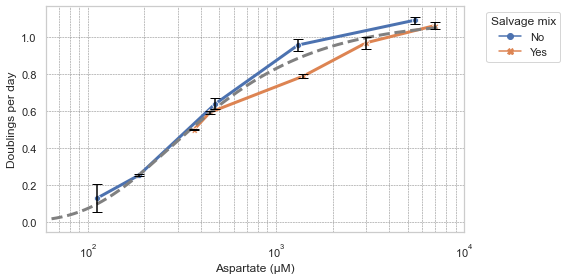

In [238]:
### Proliferation rate as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Proliferation_H1299_err_log_sig.pdf")
fig = plt.figure(figsize=(8, 4))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='Proliferation_rate', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False, linewidth=3)
#g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=5)
g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=5, zorder=10)

g.set(xscale="log");

plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
g.xaxis.set_minor_locator(locmin)
g.xaxis.set_minor_formatter(mticker.NullFormatter())
g.set(xlim=(60, 10000))


plt.ylabel('Doublings per day', size=12);
plt.xlabel('Aspartate (μM)', size=12);

### Plot sigmoid fit ###
plt.plot(10**x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]), '--', linewidth=3, color='gray')
######################

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

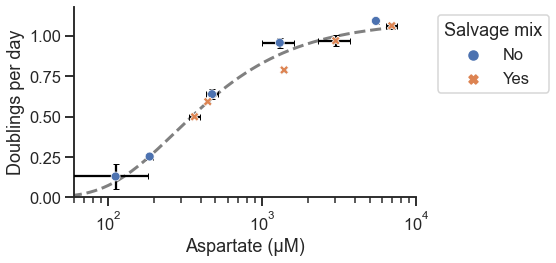

In [464]:
### Proliferation rate as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Proliferation_H1299_err_log_sig.pdf")
fig = plt.figure(figsize=(8, 4))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
#mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.scatterplot(data=df_mean[mask1], x='Aspartate conc', y='Proliferation_rate', hue='Salvage_mix',
             style='Salvage_mix', markers=True, zorder=11, s=80)
g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=3, zorder=10)
#g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=5, zorder=10)

g.set(xscale="log");
g.set(xlim=(60, 10000))
g.set(ylim=(0, 1.18))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)


plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);

if True:
    ### Plot sigmoid fit ###
    plt.plot(10**x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]), '--', linewidth=3, color='gray')
    ######################

sns.despine()


plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

<ipython-input-13-81aa7ce72bfb>:11: RuntimeWarning: divide by zero encountered in double_scalars
  return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))
<ipython-input-13-81aa7ce72bfb>:11: RuntimeWarning: overflow encountered in power
  return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))


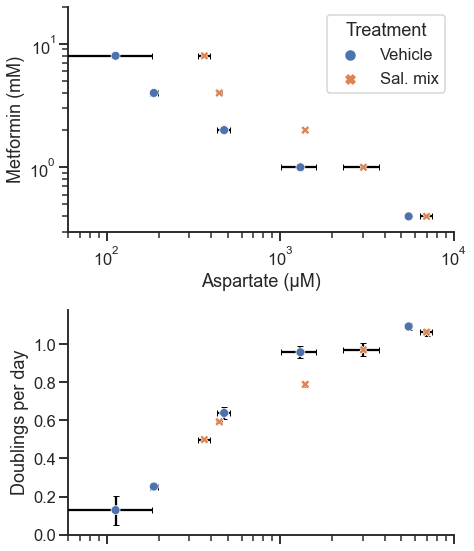

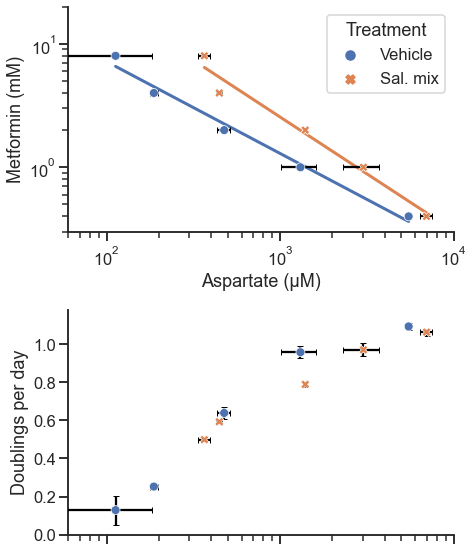

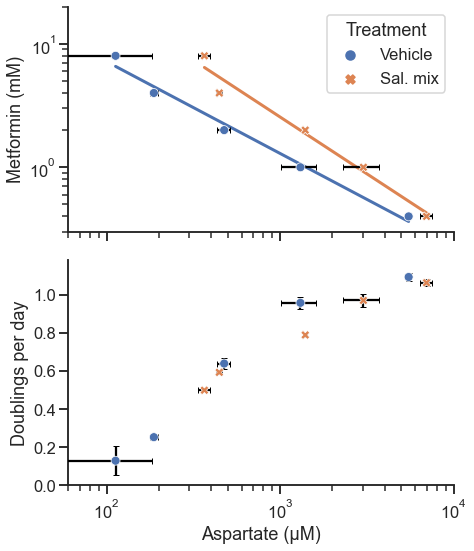

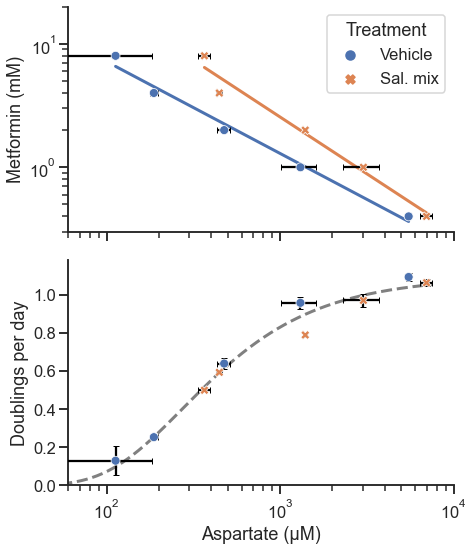

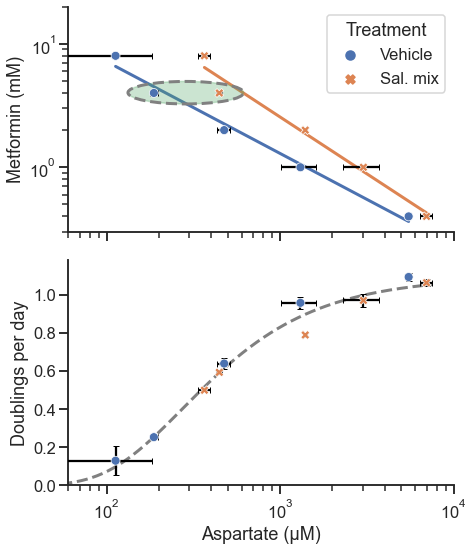

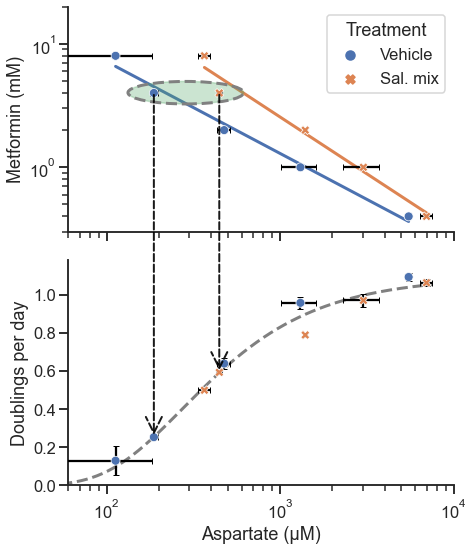

In [13]:
### Generate sigmoid fit for proliferation data ###
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
prof_max = df_mean[mask1]['Proliferation_rate'].max()

mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
x = np.array([np.log10(x) for x in df[mask]['Aspartate conc']])
y = np.array([y for y in df[mask]['Proliferation_rate']])


def sig_fit(asp_conc, prof_max, Q, B, v):
    return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))

def sig_fit_loss(mes_prof, asp_conc, prof_max, p):
    pred_prof = sig_fit(asp_conc, prof_max, p[0], p[1], p[2])
    return(sum((mes_prof-pred_prof)**2))

bnds = ((0, None), (0, None), (0, None))
def fun_sig_fit(p): return(sig_fit_loss(y, x, prof_max, p))
p_sig_fit = minimize(fun_sig_fit, (1, 1, 1), method='L-BFGS-B', bounds=bnds)

#sns.scatterplot(x, y)
x_sig = np.arange(min(x), max(x), 0.01)
#plt.plot(x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]))






#### Plot progressive plot for presentation ####
for plot_i in range(6):
    pdf = matplotlib.backends.backend_pdf.PdfPages('presi_plot_{}.pdf'.format(plot_i))
    fig, axes = plt.subplots(2, figsize=(7, 8))
    mask = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)

    if plot_i >= 0:
        ### Metformin as a function of Aspartate ###
        g1 = sns.scatterplot(ax=axes[0], data=df_mean[mask], x='Aspartate conc', y='Metformin', hue='Salvage_mix',
                     style='Salvage_mix', markers=True, zorder=13, s=80)
        g1.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3, zorder=12)

        g1.set(yscale="log", xscale="log");
        g1.set(xlim=(60, 10000), ylim=(0.3, 20))
        #axes[0].legend(loc="upper right", title='Salvage mix')
        handles, labels = g1.get_legend_handles_labels()
        axes[0].legend(loc="upper right", title='Treatment', labels=['Vehicle', 'Sal. mix'], handles=handles)
        if plot_i < 2:
            g1.set(xlabel='Aspartate (μM)', ylabel='Metformin (mM)')
        else:
            g1.set(xlabel=None, ylabel='Metformin (mM)', xticklabels=[])
        sns.despine()


    if plot_i >= 1:
        ### Fit regression ###
        x_no = np.array([np.log10(x) for x, b in zip(df_mean[mask]['Aspartate conc'], df_mean[mask]['Salvage_mix']) if b == 'No' ])
        y_no = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'No' ])

        x_yes = np.array([np.log10(x) for x, b in zip(df_mean[mask]['Aspartate conc'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])
        y_yes = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])

        b_no, m_no = polyfit(x_no, y_no, 1)
        b_yes, m_yes = polyfit(x_yes, y_yes, 1)

        axes[0].plot(10**x_no, 10**(b_no + m_no * x_no), '-', linewidth=3, zorder=9)
        axes[0].plot(10**x_yes, 10**(b_yes + m_yes * x_yes), '-', linewidth=3, zorder=9)


    if plot_i >= 0:
        ### Proliferation rate as a function of Aspartate ###
        g2 = sns.scatterplot(ax=axes[1], data=df_mean[mask], x='Aspartate conc', y='Proliferation_rate', hue='Salvage_mix', style='Salvage_mix', markers=True, zorder=11, s=80)
        g2.errorbar(y=df_mean[mask]['Proliferation_rate'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Proliferation_rate'].values, fmt='none', color='black', capsize=3, zorder=10)

        g2.set(xscale="log");
        g2.set(xlim=(60, 10000), ylim=(0, 1.18))
        g2.legend_.remove()
        if plot_i >= 2:
            g2.set(xlabel='Aspartate (μM)', ylabel='Doublings per day')
        else:
            g2.set(xlabel=None, ylabel='Doublings per day', xticklabels=[])
        sns.despine()
    
    if plot_i >= 3:
        ### Plot sigmoid fit ###
        axes[1].plot(10**x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]), '--', linewidth=3, color='gray')


    if plot_i >= 4:
        axes[0].add_patch(matplotlib.patches.Ellipse((0.305, 0.618), 0.3, 0.1, alpha=0.3, color="g", transform=axes[0].transAxes, zorder=10))
        axes[0].add_patch(matplotlib.patches.Ellipse((0.305, 0.618), 0.3, 0.1, alpha=1, transform=axes[0].transAxes, zorder=10, edgecolor='gray', linestyle='--', linewidth=3, fill=False))

        
    if plot_i >= 5:
        plt.tight_layout() # This rescales as moves around the arrows
        
        entry_no = df_mean[(df_mean['Metformin'] == 4) &(df_mean['Salvage_mix'] == 'No') & mask]
        no_x = entry_no['Aspartate conc'].values[0]
        upper_no_y = entry_no['Metformin'].values[0]
        lower_no_y = entry_no['Proliferation_rate'].values[0]

        entry_yes = df_mean[(df_mean['Metformin'] == 4) &(df_mean['Salvage_mix'] == 'Yes') & mask]
        yes_x = entry_yes['Aspartate conc'].values[0]
        upper_yes_y = entry_yes['Metformin'].values[0]
        lower_yes_y = entry_yes['Proliferation_rate'].values[0]

        # Create the arrow
        # 1. Get transformation operators for axis and figure
        ax0tr = axes[0].transData # Axis 0 -> Display
        ax1tr = axes[1].transData # Axis 1 -> Display
        figtr = fig.transFigure.inverted() # Display -> Figure
        # 2. Transform arrow start point from axis 0 to figure coordinates
        ptB_no = figtr.transform(ax0tr.transform((no_x, upper_no_y)))
        ptB_yes = figtr.transform(ax0tr.transform((yes_x, upper_yes_y)))
        # 3. Transform arrow end point from axis 1 to figure coordinates
        ptE_no = figtr.transform(ax1tr.transform((no_x, lower_no_y)))
        ptE_yes = figtr.transform(ax1tr.transform((yes_x, lower_yes_y)))
        # 4. Create the patch
        arrow_no = matplotlib.patches.FancyArrowPatch(
            ptB_no, ptE_no, transform=fig.transFigure,  # Place arrow in figure coord system
            fc = "black", connectionstyle="arc3,rad=0.0", arrowstyle='->', alpha = 0.9,
            mutation_scale = 40, edgecolor='black', ls='--', linewidth=2, zorder=10
        )
        arrow_yes = matplotlib.patches.FancyArrowPatch(
            ptB_yes, ptE_yes, transform=fig.transFigure,  # Place arrow in figure coord system
            fc = "black", connectionstyle="arc3,rad=0.0", arrowstyle='->', alpha = 0.9,
            mutation_scale = 40, edgecolor='black', ls='--', linewidth=2, zorder=10
        )
        # 5. Add patch to list of objects to draw onto the figure
        fig.patches.append(arrow_no)
        fig.patches.append(arrow_yes)

    if plot_i < 5:
        plt.tight_layout()
    pdf.savefig(fig)
    plt.show(fig)
    plt.close(fig)
    pdf.close()

<ipython-input-23-650216b211a8>:11: RuntimeWarning: divide by zero encountered in double_scalars
  return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))
<ipython-input-23-650216b211a8>:11: RuntimeWarning: overflow encountered in power
  return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))


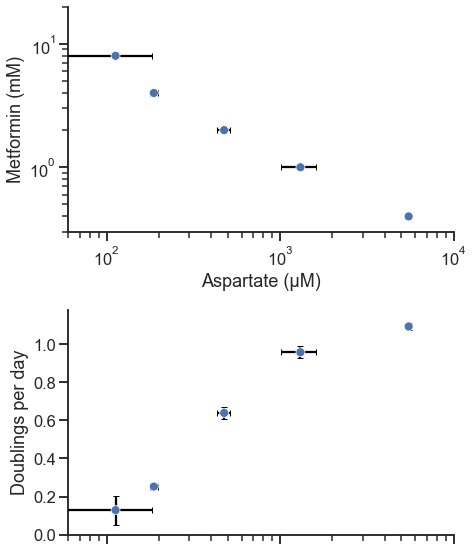

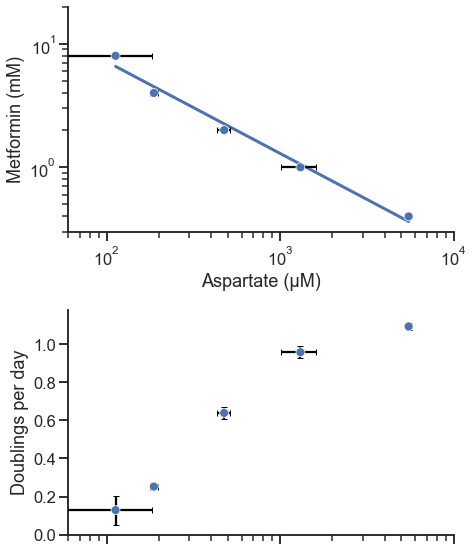

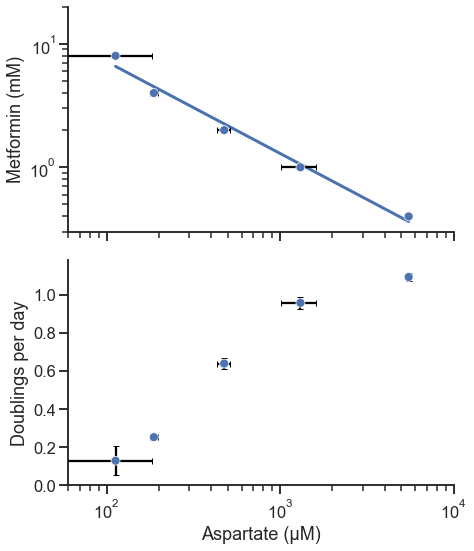

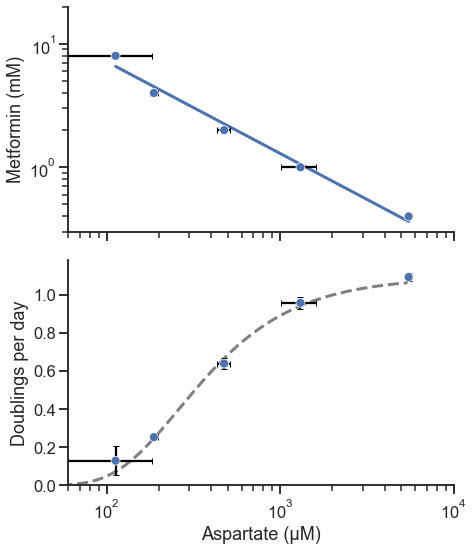

In [23]:
### Generate sigmoid fit for proliferation data ###
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14) & (df_mean['Salvage_mix'] == 'No')
prof_max = df_mean[mask1]['Proliferation_rate'].max()

mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14) & (df['Salvage_mix'] == 'No')
x = np.array([np.log10(x) for x in df[mask]['Aspartate conc']])
y = np.array([y for y in df[mask]['Proliferation_rate']])


def sig_fit(asp_conc, prof_max, Q, B, v):
    return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))

def sig_fit_loss(mes_prof, asp_conc, prof_max, p):
    pred_prof = sig_fit(asp_conc, prof_max, p[0], p[1], p[2])
    return(sum((mes_prof-pred_prof)**2))

bnds = ((0, None), (0, None), (0, None))
def fun_sig_fit(p): return(sig_fit_loss(y, x, prof_max, p))
p_sig_fit = minimize(fun_sig_fit, (1, 1, 1), method='L-BFGS-B', bounds=bnds)

#sns.scatterplot(x, y)
x_sig = np.arange(min(x), max(x), 0.01)
#plt.plot(x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]))






#### Plot progressive plot for presentation ####
for plot_i in range(4):
    pdf = matplotlib.backends.backend_pdf.PdfPages('presi_plot_nosal_{}.pdf'.format(plot_i))
    fig, axes = plt.subplots(2, figsize=(7, 8))
    mask = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14) & (df_mean['Salvage_mix'] == 'No')

    if plot_i >= 0:
        ### Metformin as a function of Aspartate ###
        g1 = sns.scatterplot(ax=axes[0], data=df_mean[mask], x='Aspartate conc', y='Metformin', style='Salvage_mix', markers=True, zorder=13, s=80)
        g1.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=3, zorder=12)

        g1.set(yscale="log", xscale="log");
        g1.set(xlim=(60, 10000), ylim=(0.3, 20))
        g1.legend_.remove()
        if plot_i < 2:
            g1.set(xlabel='Aspartate (μM)', ylabel='Metformin (mM)')
        else:
            g1.set(xlabel=None, ylabel='Metformin (mM)', xticklabels=[])
        sns.despine()


    if plot_i >= 1:
        ### Fit regression ###
        x_no = np.array([np.log10(x) for x, b in zip(df_mean[mask]['Aspartate conc'], df_mean[mask]['Salvage_mix']) if b == 'No' ])
        y_no = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'No' ])

        b_no, m_no = polyfit(x_no, y_no, 1)

        axes[0].plot(10**x_no, 10**(b_no + m_no * x_no), '-', linewidth=3, zorder=9)


    if plot_i >= 0:
        ### Proliferation rate as a function of Aspartate ###
        g2 = sns.scatterplot(ax=axes[1], data=df_mean[mask], x='Aspartate conc', y='Proliferation_rate', style='Salvage_mix', markers=True, zorder=11, s=80)
        g2.errorbar(y=df_mean[mask]['Proliferation_rate'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, yerr=df_stdev[mask]['Proliferation_rate'].values, fmt='none', color='black', capsize=3, zorder=10)

        g2.set(xscale="log");
        g2.set(xlim=(60, 10000), ylim=(0, 1.18))
        g2.legend_.remove()
        if plot_i >= 2:
            g2.set(xlabel='Aspartate (μM)', ylabel='Doublings per day')
        else:
            g2.set(xlabel=None, ylabel='Doublings per day', xticklabels=[])
        sns.despine()
    
    if plot_i >= 3:
        ### Plot sigmoid fit ###
        axes[1].plot(10**x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]), '--', linewidth=3, color='gray')


    fig.tight_layout()
    pdf.savefig(fig)
    plt.show(fig)
    plt.close(fig)
    pdf.close()

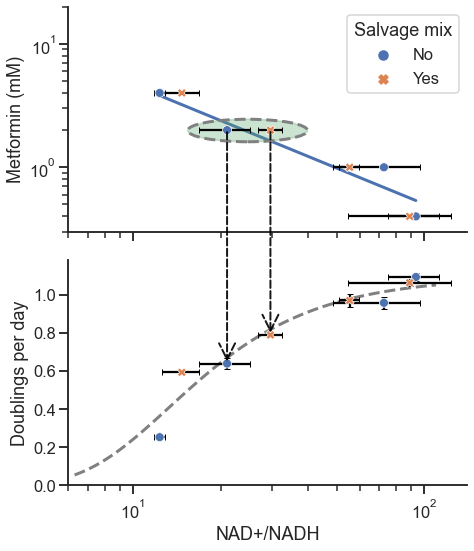

In [17]:
### Generate sigmoid fit for proliferation data ###
mask1 = (df_mean['Cell_line']=='H1299') & \
       (((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'No')))

prof_max = df_mean[mask1]['Proliferation_rate'].max()

mask = (df['Cell_line']=='H1299') & \
       (((df['Metformin'] < 7) & (df['Salvage_mix'] == 'Yes')) | \
        ((df['Metformin'] < 7) & (df['Salvage_mix'] == 'No')))
x = np.array([np.log10(x) for x in df[mask]['NAD-NADH_RR']])
y = np.array([y for y in df[mask]['Proliferation_rate']])


def sig_fit(asp_conc, prof_max, Q, B, v):
    return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))

def sig_fit_loss(mes_prof, asp_conc, prof_max, p):
    pred_prof = sig_fit(asp_conc, prof_max, p[0], p[1], p[2])
    return(sum((mes_prof-pred_prof)**2))

bnds = ((0, None), (0, None), (0, None))
def fun_sig_fit(p): return(sig_fit_loss(y, x, prof_max, p))
p_sig_fit = minimize(fun_sig_fit, (1, 1, 1), method='L-BFGS-B', bounds=bnds)

#sns.scatterplot(x, y)
x_sig = np.arange(0.8, max(x), 0.01)
#plt.plot(x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]))






#### Plot progressive plot for presentation ####
for plot_i in range(5, 6):
    pdf = matplotlib.backends.backend_pdf.PdfPages('NAD-presi_plot_{}.pdf'.format(plot_i))
    fig, axes = plt.subplots(2, figsize=(7, 8))
    mask = (df_mean['Cell_line']=='H1299') & \
           (((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'Yes')) | \
            ((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'No')))

    if plot_i >= 0:
        ### Metformin as a function of Aspartate ###
        g1 = sns.scatterplot(ax=axes[0], data=df_mean[mask], x='NAD-NADH_RR', y='Metformin', hue='Salvage_mix',
                     style='Salvage_mix', markers=True, zorder=13, s=80)
        g1.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['NAD-NADH_RR'].values, xerr=df_stdev[mask]['NAD-NADH_RR'].values, fmt='none', color='black', capsize=3, zorder=12)

        g1.set(yscale="log", xscale="log");
        g1.set(xlim=(6, 140), ylim=(0.3, 20))
        axes[0].legend(loc="upper right", title='Salvage mix')
        if plot_i < 2:
            g1.set(xlabel='NAD+/NADH', ylabel='Metformin (mM)')
        else:
            g1.set(xlabel=None, ylabel='Metformin (mM)', xticklabels=[])
        sns.despine()


    if plot_i >= 1:
        ### Fit regression ###
        x_no = np.array([np.log10(x) for x, b in zip(df_mean[mask]['NAD-NADH_RR'], df_mean[mask]['Salvage_mix']) if b == 'No' ])
        y_no = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'No' ])

        x_yes = np.array([np.log10(x) for x, b in zip(df_mean[mask]['NAD-NADH_RR'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])
        y_yes = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])

        b_no, m_no = polyfit(x_no, y_no, 1)
        b_yes, m_yes = polyfit(x_yes, y_yes, 1)

        axes[0].plot(10**x_no, 10**(b_no + m_no * x_no), '-', linewidth=3, zorder=9)
        axes[0].plot(10**x_yes, 10**(b_yes + m_yes * x_yes), '-', linewidth=3, zorder=9)


    if plot_i >= 0:
        ### Proliferation rate as a function of Aspartate ###
        g2 = sns.scatterplot(ax=axes[1], data=df_mean[mask], x='NAD-NADH_RR', y='Proliferation_rate', hue='Salvage_mix', style='Salvage_mix', markers=True, zorder=11, s=80)
        g2.errorbar(y=df_mean[mask]['Proliferation_rate'].values, x=df_mean[mask]['NAD-NADH_RR'].values, xerr=df_stdev[mask]['NAD-NADH_RR'].values, yerr=df_stdev[mask]['Proliferation_rate'].values, fmt='none', color='black', capsize=3, zorder=10)

        g2.set(xscale="log");
        g2.set(xlim=(6, 140), ylim=(0, 1.18))
        g2.legend_.remove()
        if plot_i >= 2:
            g2.set(xlabel='NAD+/NADH', ylabel='Doublings per day')
        else:
            g2.set(xlabel=None, ylabel='Doublings per day', xticklabels=[])
        sns.despine()
    
    if plot_i >= 3:
        ### Plot sigmoid fit ###
        axes[1].plot(10**x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]), '--', linewidth=3, color='gray')


    if plot_i >= 4:
        axes[0].add_patch(matplotlib.patches.Ellipse((0.45, 0.45), 0.3, 0.1, alpha=0.3, color="g", transform=axes[0].transAxes, zorder=10))
        axes[0].add_patch(matplotlib.patches.Ellipse((0.45, 0.45), 0.3, 0.1, alpha=1, transform=axes[0].transAxes, zorder=10, edgecolor='gray', linestyle='--', linewidth=3, fill=False))

        
    if plot_i >= 5:
        plt.tight_layout() # This rescales as moves around the arrows
        
        entry_no = df_mean[(df_mean['Metformin'] == 2) &(df_mean['Salvage_mix'] == 'No') & mask]
        no_x = entry_no['NAD-NADH_RR'].values[0]
        upper_no_y = entry_no['Metformin'].values[0]
        lower_no_y = entry_no['Proliferation_rate'].values[0]

        entry_yes = df_mean[(df_mean['Metformin'] == 2) &(df_mean['Salvage_mix'] == 'Yes') & mask]
        yes_x = entry_yes['NAD-NADH_RR'].values[0]
        upper_yes_y = entry_yes['Metformin'].values[0]
        lower_yes_y = entry_yes['Proliferation_rate'].values[0]

        # Create the arrow
        # 1. Get transformation operators for axis and figure
        ax0tr = axes[0].transData # Axis 0 -> Display
        ax1tr = axes[1].transData # Axis 1 -> Display
        figtr = fig.transFigure.inverted() # Display -> Figure
        # 2. Transform arrow start point from axis 0 to figure coordinates
        ptB_no = figtr.transform(ax0tr.transform((no_x, upper_no_y)))
        ptB_yes = figtr.transform(ax0tr.transform((yes_x, upper_yes_y)))
        # 3. Transform arrow end point from axis 1 to figure coordinates
        ptE_no = figtr.transform(ax1tr.transform((no_x, lower_no_y)))
        ptE_yes = figtr.transform(ax1tr.transform((yes_x, lower_yes_y)))
        # 4. Create the patch
        arrow_no = matplotlib.patches.FancyArrowPatch(
            ptB_no, ptE_no, transform=fig.transFigure,  # Place arrow in figure coord system
            fc = "black", connectionstyle="arc3,rad=0.0", arrowstyle='->', alpha = 0.9,
            mutation_scale = 40, edgecolor='black', ls='--', linewidth=2, zorder=10
        )
        arrow_yes = matplotlib.patches.FancyArrowPatch(
            ptB_yes, ptE_yes, transform=fig.transFigure,  # Place arrow in figure coord system
            fc = "black", connectionstyle="arc3,rad=0.0", arrowstyle='->', alpha = 0.9,
            mutation_scale = 40, edgecolor='black', ls='--', linewidth=2, zorder=10
        )
        # 5. Add patch to list of objects to draw onto the figure
        fig.patches.append(arrow_no)
        fig.patches.append(arrow_yes)

    if plot_i < 5:
        plt.tight_layout()
    pdf.savefig(fig)
    plt.show(fig)
    plt.close(fig)
    pdf.close()

<ipython-input-489-87b5362314b1>:16: RuntimeWarning: divide by zero encountered in double_scalars
  return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))
<ipython-input-489-87b5362314b1>:16: RuntimeWarning: overflow encountered in power
  return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


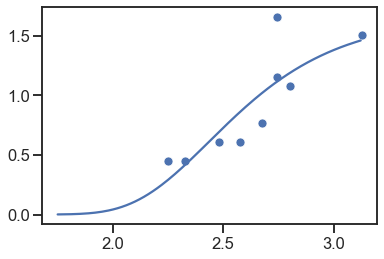

In [489]:
### Generate sigmoid fit for proliferation data ###

mask1 = (df_mean['Cell_line']=='143B') & \
       (((df_mean['Metformin'] < 1.3) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 1.1) & (df_mean['Salvage_mix'] == 'No')))
prof_max = df_mean[mask1]['Proliferation_rate'].max()

mask = (df['Cell_line']=='143B') & \
       (((df['Metformin'] < 1.3) & (df['Salvage_mix'] == 'Yes')) | \
        ((df['Metformin'] < 1.1) & (df['Salvage_mix'] == 'No')))
x = np.array([np.log10(x) for x in df_mean[mask1]['Aspartate conc']])
y = np.array([y for y in df_mean[mask1]['Proliferation_rate']])


def sig_fit(asp_conc, prof_max, Q, B, v):
    return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))

def sig_fit_loss(mes_prof, asp_conc, prof_max, p):
    pred_prof = sig_fit(asp_conc, prof_max, p[0], p[1], p[2])
    return(sum((mes_prof-pred_prof)**2))

bnds = ((0, None), (0, None), (0, None))
def fun_sig_fit(p): return(sig_fit_loss(y, x, prof_max, p))
p_sig_fit = minimize(fun_sig_fit, (1, 1, 1), method='L-BFGS-B', bounds=bnds)

sns.scatterplot(x, y)
x_sig = np.arange(min(x)-0.5, max(x), 0.01)
plt.plot(x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]))

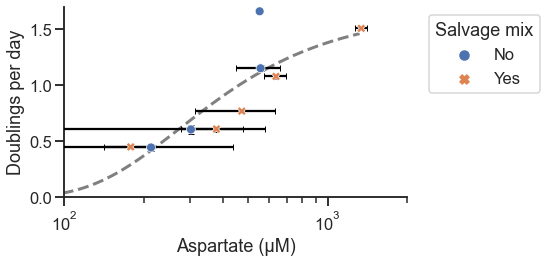

In [490]:
### Proliferation rate as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Proliferation_143B_err_log_sig.pdf")
fig = plt.figure(figsize=(8, 4))
mask1 = (df_mean['Cell_line']=='143B') & \
       (((df_mean['Metformin'] < 1.3) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 1.1) & (df_mean['Salvage_mix'] == 'No')))
#mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.scatterplot(data=df_mean[mask1], x='Aspartate conc', y='Proliferation_rate', hue='Salvage_mix',
             style='Salvage_mix', markers=True, zorder=11, s=80)
g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=3, zorder=10)
#g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=5, zorder=10)

g.set(xscale="log");
g.set(xlim=(100, 2000))
g.set(ylim=(0, 1.7))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)


plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);

if True:
    ### Plot sigmoid fit ###
    plt.plot(10**x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]), '--', linewidth=3, color='gray')
    ######################

sns.despine()


plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

In [11]:
df_mean[mask1].loc[:, ['Metformin', 'Salvage_mix', 'Aspartate conc']]

,Metformin,Salvage_mix,Aspartate conc
2,0.4,No,5500.319410
3,0.4,Yes,6972.389920
9,1.0,No,1307.893479
11,1.0,Yes,3017.192331
15,2.0,No,475.288556
16,2.0,Yes,1394.418767
17,4.0,No,186.986690
18,4.0,Yes,445.566170
19,8.0,No,112.480328
20,8.0,Yes,365.628376


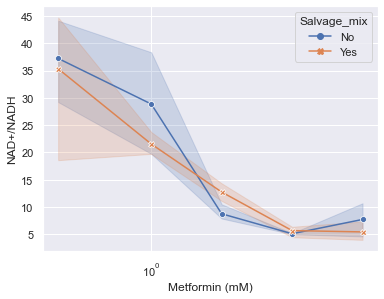

In [12]:
### NAD/NADH ratio as a function of Metformin ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Met_vs_NAD-NADH_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.lineplot(data=df[mask1], x='Metformin', y='NAD-NADH', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)
g.set(xscale="log");

plt.ylabel('NAD+/NADH', size=12);
plt.xlabel('Metformin (mM)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

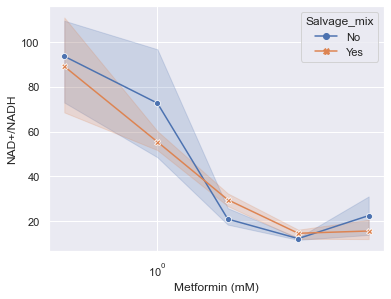

In [45]:
### NAD/NADH ratio as a function of Metformin ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Met_vs_NAD-NADH-RR_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.lineplot(data=df[mask1], x='Metformin', y='NAD-NADH_RR', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)
g.set(xscale="log");

plt.ylabel('NAD+/NADH', size=12);
plt.xlabel('Metformin (mM)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

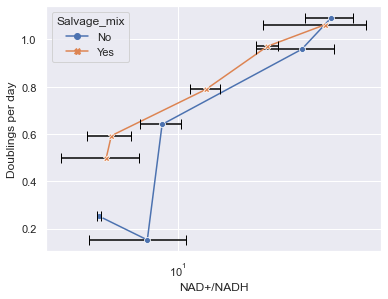

In [13]:
### Proliferation rate as a function of NAD+/NADH ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_Proliferation_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask1], x='NAD-NADH', y='Proliferation_rate', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['NAD-NADH'].values, xerr=df_stdev[mask1]['NAD-NADH'].values, fmt='none', color='black', capsize=5)

g.set(xscale="log");

plt.ylabel('Doublings per day', size=12);
plt.xlabel('NAD+/NADH', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

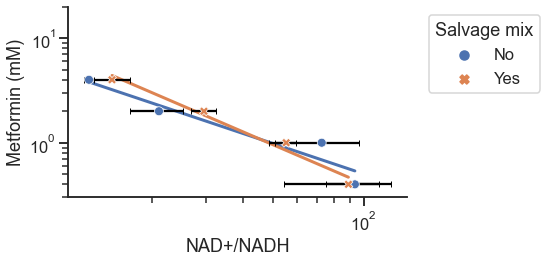

In [452]:
### Metformin as a function of NAD+/NADH ratio ###
pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_Met_H1299_dlog_err_reg.pdf")
fig = plt.figure(figsize=(8, 4))

mask = (df_mean['Cell_line']=='H1299') & \
       (((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'No')))
g = sns.scatterplot(data=df_mean[mask], x='NAD-NADH_RR', y='Metformin', hue='Salvage_mix',
             style='Salvage_mix', markers=True, zorder=11, s=80)
g.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['NAD-NADH_RR'].values, xerr=df_stdev[mask]['NAD-NADH_RR'].values, fmt='none', color='black', capsize=3, zorder=10)
g.set(yscale="log");
g.set(xscale="log");

g.set(ylim=(0.3, 20))
#g.set(xlim=(60, 10000))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)
    

plt.ylabel('Metformin (mM)')#, size=12);
plt.xlabel('NAD+/NADH')#, size=12);


if True:
    ### Fit regression ###
    x_no = np.array([np.log10(x) for x, b in zip(df_mean[mask]['NAD-NADH_RR'], df_mean[mask]['Salvage_mix']) if b == 'No' ])
    y_no = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'No' ])

    x_yes = np.array([np.log10(x) for x, b in zip(df_mean[mask]['NAD-NADH_RR'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])
    y_yes = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])

    b_no, m_no = polyfit(x_no, y_no, 1)
    b_yes, m_yes = polyfit(x_yes, y_yes, 1)

    plt.plot(10**x_no, 10**(b_no + m_no * x_no), '-', linewidth=3)
    plt.plot(10**x_yes, 10**(b_yes + m_yes * x_yes), '-', linewidth=3)

    ######################

sns.despine()
    

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

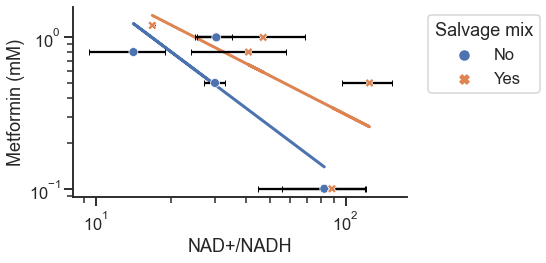

In [499]:
### Metformin as a function of NAD+/NADH ratio ###
pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_Met_143B_dlog_err_reg.pdf")
fig = plt.figure(figsize=(8, 4))

mask = (df_mean['Cell_line']=='143B') & \
       (((df_mean['Metformin'] < 1.3) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 1.1) & (df_mean['Salvage_mix'] == 'No')))
g = sns.scatterplot(data=df_mean[mask], x='NAD-NADH_RR', y='Metformin', hue='Salvage_mix',
             style='Salvage_mix', markers=True, zorder=11, s=80)
g.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['NAD-NADH_RR'].values, xerr=df_stdev[mask]['NAD-NADH_RR'].values, fmt='none', color='black', capsize=3, zorder=10)
g.set(yscale="log");
g.set(xscale="log");

#g.set(ylim=(0.3, 20))
#g.set(xlim=(60, 10000))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)
    

plt.ylabel('Metformin (mM)')#, size=12);
plt.xlabel('NAD+/NADH')#, size=12);


if True:
    ### Fit regression ###
    x_no = np.array([np.log10(x) for x, b in zip(df_mean[mask]['NAD-NADH_RR'], df_mean[mask]['Salvage_mix']) if b == 'No' ])
    y_no = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'No' ])

    x_yes = np.array([np.log10(x) for x, b in zip(df_mean[mask]['NAD-NADH_RR'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])
    y_yes = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])

    b_no, m_no = polyfit(x_no, y_no, 1)
    b_yes, m_yes = polyfit(x_yes, y_yes, 1)

    plt.plot(10**x_no, 10**(b_no + m_no * x_no), '-', linewidth=3)
    plt.plot(10**x_yes, 10**(b_yes + m_yes * x_yes), '-', linewidth=3)

    ######################

sns.despine()
    

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


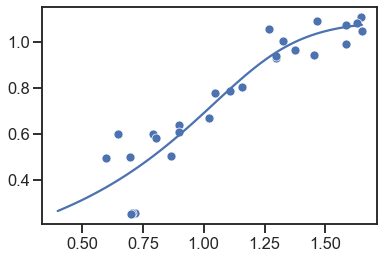

In [453]:
### Generate sigmoid fit for proliferation data ###

mask1 = (df_mean['Cell_line']=='H1299') & \
       (((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'No')))
prof_max = df_mean[mask1]['Proliferation_rate'].max()

mask = (df['Cell_line']=='H1299') & \
       (((df['Metformin'] < 14) & (df['Salvage_mix'] == 'Yes')) | \
        ((df['Metformin'] < 7) & (df['Salvage_mix'] == 'No')))
x = np.array([np.log10(x) for x in df[mask]['NAD-NADH']])
y = np.array([y for y in df[mask]['Proliferation_rate']])


def sig_fit(asp_conc, prof_max, Q, B, v):
    return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))

def sig_fit_loss(mes_prof, asp_conc, prof_max, p):
    pred_prof = sig_fit(asp_conc, prof_max, p[0], p[1], p[2])
    return(sum((mes_prof-pred_prof)**2))

bnds = ((0, None), (0, None), (0, None))
def fun_sig_fit(p): return(sig_fit_loss(y, x, prof_max, p))
p_sig_fit = minimize(fun_sig_fit, (1, 1, 1), method='L-BFGS-B', bounds=bnds)

sns.scatterplot(x, y)
x_sig = np.arange(0.4, max(x), 0.01)
plt.plot(x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]))

<ipython-input-454-ca0d662cb5e6>:14: RuntimeWarning: divide by zero encountered in double_scalars
  return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))
<ipython-input-454-ca0d662cb5e6>:14: RuntimeWarning: overflow encountered in power
  return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


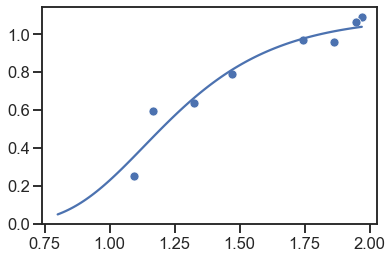

In [454]:
### Generate sigmoid fit for proliferation data ###

mask1 = (df_mean['Cell_line']=='H1299') & \
       (((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'No')))
prof_max = df_mean[mask1]['Proliferation_rate'].max()

#mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
x = np.array([np.log10(x) for x in df_mean[mask1]['NAD-NADH_RR']])
y = np.array([y for y in df_mean[mask1]['Proliferation_rate']])


def sig_fit(asp_conc, prof_max, Q, B, v):
    return(prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))

def sig_fit_loss(mes_prof, asp_conc, prof_max, p):
    pred_prof = sig_fit(asp_conc, prof_max, p[0], p[1], p[2])
    return(sum((mes_prof-pred_prof)**2))

bnds = ((0, None), (0, None), (0, None))
def fun_sig_fit(p): return(sig_fit_loss(y, x, prof_max, p))
p_sig_fit = minimize(fun_sig_fit, (1, 1, 1), method='L-BFGS-B', bounds=bnds)

sns.scatterplot(x, y)
x_sig = np.arange(0.8, max(x), 0.01)
plt.plot(x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]))

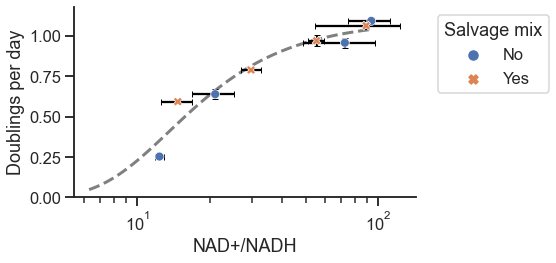

In [455]:
### Proliferation rate as a function of NAD+/NADH ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_Proliferation_H1299.pdf")
fig = plt.figure(figsize=(8, 4))
mask1 = (df_mean['Cell_line']=='H1299') & \
       (((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'No')))
#mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.scatterplot(data=df_mean[mask1], x='NAD-NADH_RR', y='Proliferation_rate', hue='Salvage_mix',
             style='Salvage_mix', markers=True, zorder=11, s=80)
g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['NAD-NADH_RR'].values, xerr=df_stdev[mask1]['NAD-NADH_RR'].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=3, zorder=10)
#g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=5, zorder=10)

g.set(xscale="log");
#g.set(xlim=(60, 10000))
g.set(ylim=(0, 1.18))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)


plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('NAD+/NADH')#, size=12);

if True:
    ### Plot sigmoid fit ###
    plt.plot(10**x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]), '--', linewidth=3, color='gray')
    ######################

sns.despine()


plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

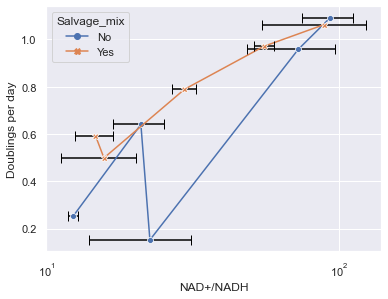

In [46]:
### Proliferation rate as a function of NAD+/NADH ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH-RR_vs_Proliferation_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask1], x='NAD-NADH_RR', y='Proliferation_rate', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['NAD-NADH_RR'].values, xerr=df_stdev[mask1]['NAD-NADH_RR'].values, fmt='none', color='black', capsize=5)

g.set(xscale="log");

plt.ylabel('Doublings per day', size=12);
plt.xlabel('NAD+/NADH', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

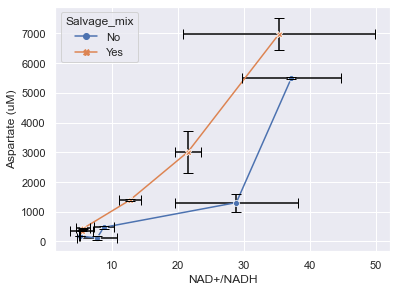

In [14]:
### Aspartate as a function of NAD/NADH ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_Asp_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask1], x='NAD-NADH', y='Aspartate conc', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['Aspartate conc'].values, x=df_mean[mask1]['NAD-NADH'].values, yerr=df_stdev[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['NAD-NADH'].values, fmt='none', color='black', capsize=5)
#g.set(xscale="log");


plt.ylabel('Aspartate (μM)', size=12);
plt.xlabel('NAD+/NADH', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

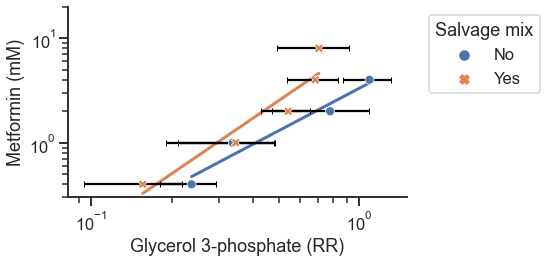

In [413]:
### Metformin as a function of NAD+/NADH ratio ###
pdf = matplotlib.backends.backend_pdf.PdfPages("G3P_vs_Met_H1299_dlog_err_reg.pdf")
fig = plt.figure(figsize=(8, 4))

mask = (df_mean['Cell_line']=='H1299') & \
       (((df_mean['Metformin'] < 14) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'No')))
g = sns.scatterplot(data=df_mean[mask], x='Glycerol 3-phosphate neg', y='Metformin', hue='Salvage_mix',
             style='Salvage_mix', markers=True, zorder=11, s=80)
g.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['Glycerol 3-phosphate neg'].values, xerr=df_stdev[mask]['Glycerol 3-phosphate neg'].values, fmt='none', color='black', capsize=3, zorder=10)
g.set(yscale="log");
g.set(xscale="log");

g.set(ylim=(0.3, 20))
#g.set(xlim=(60, 10000))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)
    

plt.ylabel('Metformin (mM)')#, size=12);
plt.xlabel('Glycerol 3-phosphate (RR)')#, size=12);


if True:
    ### Fit regression ###
    x_no = np.array([np.log10(x) for x, b in zip(df_mean[mask]['Glycerol 3-phosphate neg'], df_mean[mask]['Salvage_mix']) if b == 'No' ])
    y_no = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'No' ])

    x_yes = np.array([np.log10(x) for x, b in zip(df_mean[mask]['Glycerol 3-phosphate neg'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])
    y_yes = np.array([np.log10(y) for y, b in zip(df_mean[mask]['Metformin'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])

    b_no, m_no = polyfit(x_no, y_no, 1)
    b_yes, m_yes = polyfit(x_yes, y_yes, 1)

    plt.plot(10**x_no, 10**(b_no + m_no * x_no), '-', linewidth=3)
    plt.plot(10**x_yes, 10**(b_yes + m_yes * x_yes), '-', linewidth=3)

    ######################

sns.despine()
    

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

<ipython-input-418-2bfb3e4cbc5e>:16: RuntimeWarning: divide by zero encountered in double_scalars
  return(prof_max + -prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))
<ipython-input-418-2bfb3e4cbc5e>:16: RuntimeWarning: overflow encountered in power
  return(prof_max + -prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))
/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


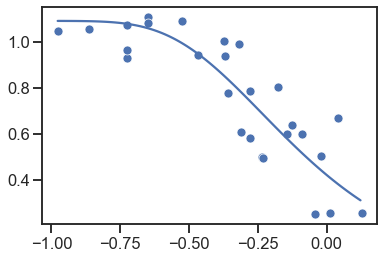

In [418]:
### Generate sigmoid fit for proliferation data ###

mask1 = (df_mean['Cell_line']=='H1299') & \
       (((df_mean['Metformin'] < 14) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'No')))
prof_max = df_mean[mask1]['Proliferation_rate'].max()

mask = (df['Cell_line']=='H1299') & \
       (((df['Metformin'] < 14) & (df['Salvage_mix'] == 'Yes')) | \
        ((df['Metformin'] < 7) & (df['Salvage_mix'] == 'No')))
x = np.array([np.log10(x) for x in df[mask]['Glycerol 3-phosphate neg']])
y = np.array([y for y in df[mask]['Proliferation_rate']])


def sig_fit(asp_conc, prof_max, Q, B, v):
    return(prof_max + -prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))

def sig_fit_loss(mes_prof, asp_conc, prof_max, p):
    pred_prof = sig_fit(asp_conc, prof_max, p[0], p[1], p[2])
    return(sum((mes_prof-pred_prof)**2))

bnds = ((0, None), (0, None), (0, None))
def fun_sig_fit(p): return(sig_fit_loss(y, x, prof_max, p))
p_sig_fit = minimize(fun_sig_fit, (1, 1, 1), method='L-BFGS-B', bounds=bnds)

sns.scatterplot(x, y)
x_sig = np.arange(min(x), max(x), 0.01)
#x_sig = np.arange(7.9, 9, 0.01)
plt.plot(x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]))


/Users/krdav/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


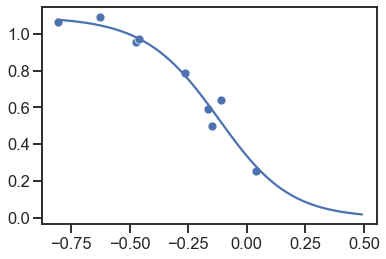

In [431]:
### Generate sigmoid fit for proliferation data ###

mask1 = (df_mean['Cell_line']=='H1299') & \
       (((df_mean['Metformin'] < 14) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'No')))
prof_max = df_mean[mask1]['Proliferation_rate'].max()

#mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
x = np.array([np.log10(x) for x in df_mean[mask1]['Glycerol 3-phosphate neg']])
y = np.array([y for y in df_mean[mask1]['Proliferation_rate']])


def sig_fit(asp_conc, prof_max, Q, B, v):
    return(prof_max + -prof_max / ((1 + Q*np.exp(-B*asp_conc))**(1/v)))

def sig_fit_loss(mes_prof, asp_conc, prof_max, p):
    pred_prof = sig_fit(asp_conc, prof_max, p[0], p[1], p[2])
    return(sum((mes_prof-pred_prof)**2))

bnds = ((0, None), (0, None), (0, None))
def fun_sig_fit(p): return(sig_fit_loss(y, x, prof_max, p))
p_sig_fit = minimize(fun_sig_fit, (1, 1, 1), method='L-BFGS-B', bounds=bnds)

sns.scatterplot(x, y)
x_sig = np.arange(min(x), max(x), 0.01)
x_sig = np.arange(min(x), 0.5, 0.01)
plt.plot(x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]))


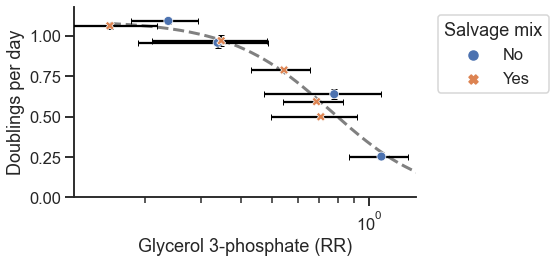

In [432]:
### Proliferation rate as a function of NAD+/NADH ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("G3P_vs_Proliferation_H1299_RR.pdf")
fig = plt.figure(figsize=(8, 4))
mask1 = (df_mean['Cell_line']=='H1299') & \
       (((df_mean['Metformin'] < 14) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'No')))
#mask = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g = sns.scatterplot(data=df_mean[mask1], x='Glycerol 3-phosphate neg', y='Proliferation_rate', hue='Salvage_mix',
             style='Salvage_mix', markers=True, zorder=11, s=80)
g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['Glycerol 3-phosphate neg'].values, xerr=df_stdev[mask1]['Glycerol 3-phosphate neg'].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=3, zorder=10)
#g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Proliferation_rate'].values, fmt='none', color='black', capsize=5, zorder=10)

g.set(xscale="log");
g.set(xlim=(0.12, 1.4))
g.set(ylim=(0, 1.18))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.xaxis.set_minor_locator(locmin)
    g.xaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)


plt.ylabel('Doublings per day')#, size=12);
plt.xlabel('Glycerol 3-phosphate (RR)')#, size=12);

if True:
    ### Plot sigmoid fit ###
    plt.plot(10**x_sig, sig_fit(x_sig, prof_max, p_sig_fit.x[0], p_sig_fit.x[1], p_sig_fit.x[2]), '--', linewidth=3, color='gray')
    ######################

sns.despine()


plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

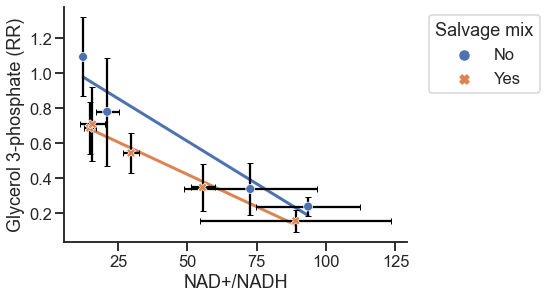

In [451]:
### Glycerol 3-phosphate as a function of NAD/NADH ratio ###
pdf = matplotlib.backends.backend_pdf.PdfPages("G3P_vs_NAD-NADH_H1299_reg.pdf")
fig = plt.figure(figsize=(8, 4.5))

mask = (df_mean['Cell_line']=='H1299') & \
       (((df_mean['Metformin'] < 14) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 7) & (df_mean['Salvage_mix'] == 'No')))
g = sns.scatterplot(data=df_mean[mask], x='NAD-NADH_RR', y='Glycerol 3-phosphate neg', hue='Salvage_mix',
             style='Salvage_mix', markers=True, zorder=11, s=80)
g.errorbar(x=df_mean[mask]['NAD-NADH_RR'].values, y=df_mean[mask]['Glycerol 3-phosphate neg'].values, yerr=df_stdev[mask]['Glycerol 3-phosphate neg'].values, xerr=df_stdev[mask]['NAD-NADH_RR'].values, fmt='none', color='black', capsize=3, zorder=10)
#g.set(yscale="log");
#g.set(xscale="log");

#g.set(ylim=(0.3, 20))
#g.set(xlim=(60, 10000))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)
    

plt.xlabel('NAD+/NADH')#, size=12);
plt.ylabel('Glycerol 3-phosphate (RR)')#, size=12);


if True:
    ### Fit regression ###
    x_no = np.array([x for x, b in zip(df_mean[mask]['NAD-NADH_RR'], df_mean[mask]['Salvage_mix']) if b == 'No' ])
    y_no = np.array([y for y, b in zip(df_mean[mask]['Glycerol 3-phosphate neg'], df_mean[mask]['Salvage_mix']) if b == 'No' ])

    x_yes = np.array([x for x, b in zip(df_mean[mask]['NAD-NADH_RR'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])
    y_yes = np.array([y for y, b in zip(df_mean[mask]['Glycerol 3-phosphate neg'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])

    b_no, m_no = polyfit(x_no, y_no, 1)
    b_yes, m_yes = polyfit(x_yes, y_yes, 1)

    plt.plot(x_no, (b_no + m_no * x_no), '-', linewidth=3)
    plt.plot(x_yes, (b_yes + m_yes * x_yes), '-', linewidth=3)

    ######################

sns.despine()
    

plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

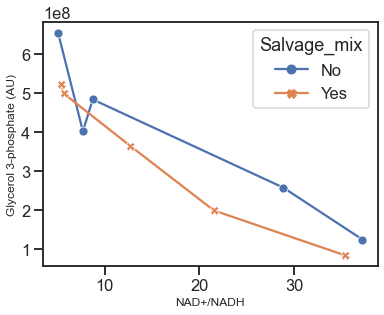

In [355]:
### Glycerol 3-phosphate as a function of NAD/NADH ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_G3P_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask1], x='NAD-NADH', y='Glycerol 3-phosphate neg', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

#g.errorbar(y=df_mean[mask1]['Glycerol 3-phosphate neg'].values, x=df_mean[mask1]['NAD-NADH'].values, yerr=df_stdev[mask1]['Glycerol 3-phosphate neg'].values, xerr=df_stdev[mask1]['NAD-NADH'].values, fmt='none', color='black', capsize=5)
#g.set(xscale="log");


plt.ylabel('Glycerol 3-phosphate (AU)', size=12);
plt.xlabel('NAD+/NADH', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

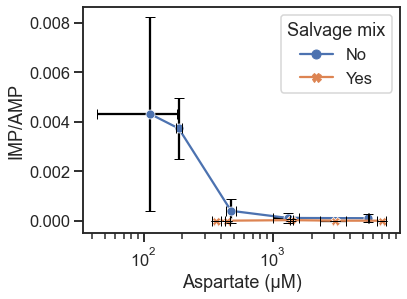

In [17]:
### IMP/AMP ratio as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_IMP-AMP_H1299_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='IMP-AMP', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['IMP-AMP'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['IMP-AMP'].values, fmt='none', color='black', capsize=5)
g.set(xscale="log");


plt.ylabel('IMP/AMP')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);
plt.legend(title='Salvage mix')

fig.tight_layout()
pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

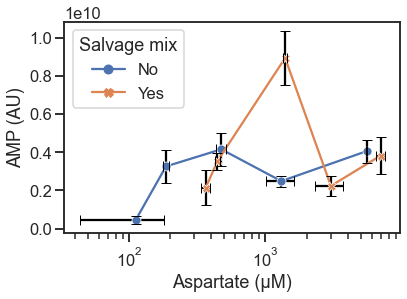

In [18]:
### AMP as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_AMP_H1299_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='AMP pos', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['AMP pos'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['AMP pos'].values, fmt='none', color='black', capsize=5)
g.set(xscale="log");


plt.ylabel('AMP (AU)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);
plt.legend(title='Salvage mix')

fig.tight_layout()
pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

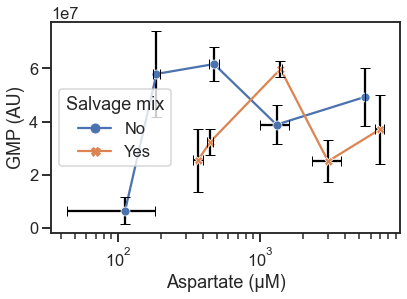

In [35]:
### GMP as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_GMP_H1299_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='GMP pos', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['GMP pos'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['GMP pos'].values, fmt='none', color='black', capsize=5)
g.set(xscale="log");


plt.ylabel('GMP (AU)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);
plt.legend(title='Salvage mix')

fig.tight_layout()
pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

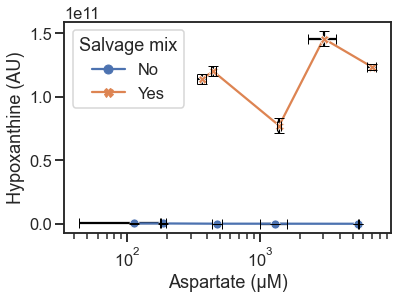

In [19]:
### Hypoxanthine as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Hypoxanthine_H1299_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='Hypoxanthine pos', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['Hypoxanthine pos'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Hypoxanthine pos'].values, fmt='none', color='black', capsize=5)
g.set(xscale="log");


plt.ylabel('Hypoxanthine (AU)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);
plt.legend(title='Salvage mix')

fig.tight_layout()
pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

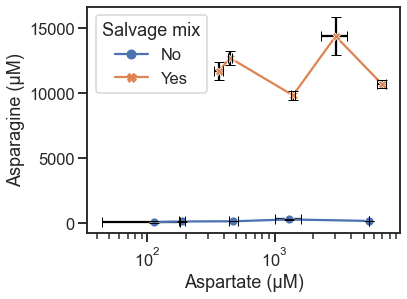

In [16]:
### Asparagine as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Asn_H1299_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='Asparagine conc', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['Asparagine conc'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Asparagine conc'].values, fmt='none', color='black', capsize=5)
g.set(xscale="log");


plt.ylabel('Asparagine (μM)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);
plt.legend(title='Salvage mix')

fig.tight_layout()
pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

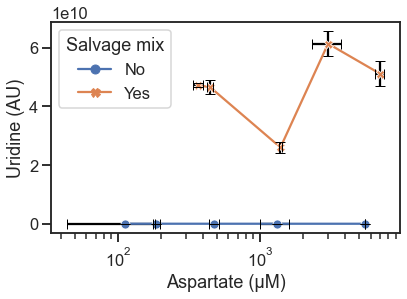

In [22]:
### Uridine as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Uridine_H1299_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='Uridine neg', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['Uridine neg'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Uridine neg'].values, fmt='none', color='black', capsize=5)
g.set(xscale="log");


plt.ylabel('Uridine (AU)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);
plt.legend(title='Salvage mix')

fig.tight_layout()
pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

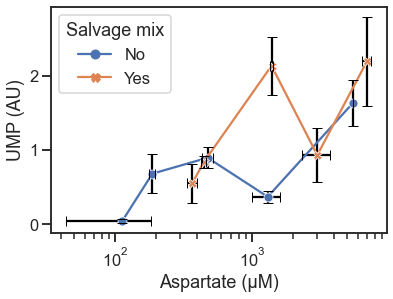

In [23]:
### UMP as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_UMP_H1299_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='UMP neg', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['UMP neg'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['UMP neg'].values, fmt='none', color='black', capsize=5)
g.set(xscale="log");


plt.ylabel('UMP (AU)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);
plt.legend(title='Salvage mix')

fig.tight_layout()
pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

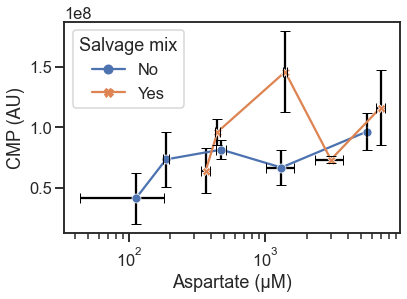

In [34]:
### CMP as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_CMP_H1299_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='CMP neg', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['CMP neg'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['CMP neg'].values, fmt='none', color='black', capsize=5)
g.set(xscale="log");


plt.ylabel('CMP (AU)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);
plt.legend(title='Salvage mix')

fig.tight_layout()
pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

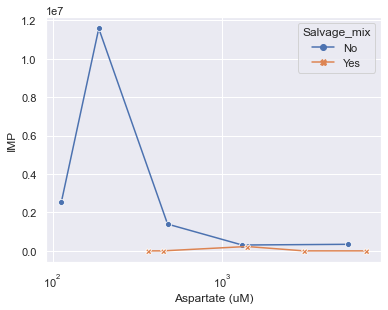

In [17]:
### IMP/AMP ratio as a function of Aspartate ###

#pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_IMP-AMP_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='IMP pos', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

#g.errorbar(y=df_mean[mask1]['IMP-AMP'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['IMP-AMP'].values, fmt='none', color='black', capsize=5)
g.set(xscale="log");


plt.ylabel('IMP', size=12);
plt.xlabel('Aspartate (μM)', size=12);

#pdf.savefig(fig)
#plt.show(fig)
#plt.close(fig)
#pdf.close()

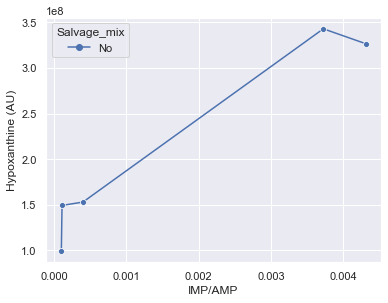

In [18]:
### Hypoxanthine as a function of IMP/AMP ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("IMP-AMP_vs_Hypoxanthine_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14) & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='IMP-AMP', y='Hypoxanthine pos', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

#g.errorbar(y=df_mean[mask1]['Hypoxanthine pos'].values, x=df_mean[mask1]['IMP-AMP'].values, xerr=df_stdev[mask1]['IMP-AMP'].values, yerr=df_stdev[mask1]['Hypoxanthine pos'].values, fmt='none', color='black', capsize=5)


plt.ylabel('Hypoxanthine (AU)', size=12);
plt.xlabel('IMP/AMP', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

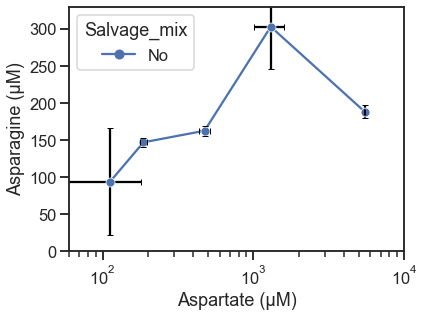

In [481]:
### Proliferation rate as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Asn_H1299_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14) & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='Asparagine conc', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.set(xscale="log");
g.set(xlim=(60, 10000))
g.set(ylim=(0, 330))

g.errorbar(y=df_mean[mask1]['Asparagine conc'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Asparagine conc'].values, fmt='none', color='black', capsize=3)


plt.ylabel('Asparagine (μM)')#, size=12);
plt.xlabel('Aspartate (μM)')#, size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

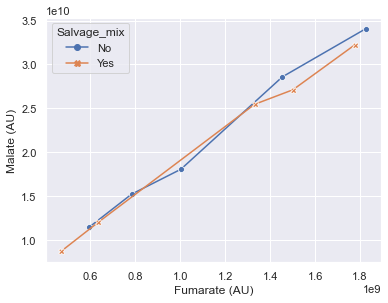

In [20]:
### Malate as a function of Fumarate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Fum_vs_Mal_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], y='Malate neg', x='Fumarate neg', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

#g.errorbar(y=df_mean[mask1]['Malate neg'].values, x=df_mean[mask1]['Fumarate neg'].values, xerr=df_stdev[mask1]['Fumarate neg'].values, yerr=df_stdev[mask1]['Malate neg'].values, fmt='none', color='black', capsize=5)

plt.ylabel('Malate (AU)', size=12);
plt.xlabel('Fumarate (AU)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

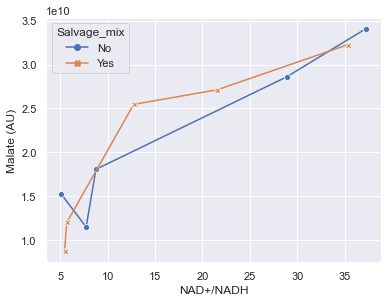

In [21]:
### Malate as a function of NAD/NADH ###

pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_Mal_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], y='Malate neg', x='NAD-NADH', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

#g.errorbar(y=df_mean[mask1]['Malate neg'].values, x=df_mean[mask1]['NAD-NADH'].values, xerr=df_stdev[mask1]['NAD-NADH'].values, yerr=df_stdev[mask1]['Malate neg'].values, fmt='none', color='black', capsize=5)

plt.ylabel('Malate (AU)', size=12);
plt.xlabel('NAD+/NADH', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

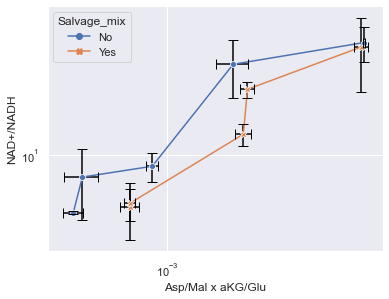

In [22]:
### NAD+/NADH ratio as a function of Asp/Mal x aKG/Glu  ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp-Mal-aKG-Glu_vs_NAD-NADH_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask1], y='NAD-NADH', x='Asp-Mal-aKG-Glu', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(x=df_mean[mask1]['Asp-Mal-aKG-Glu'].values, y=df_mean[mask1]['NAD-NADH'].values, xerr=df_stdev[mask1]['Asp-Mal-aKG-Glu'].values, yerr=df_stdev[mask1]['NAD-NADH'].values, fmt='none', color='black', capsize=5)

g.set(xscale="log");
g.set(yscale="log");

plt.ylabel('NAD+/NADH', size=12);
plt.xlabel('Asp/Mal x aKG/Glu', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

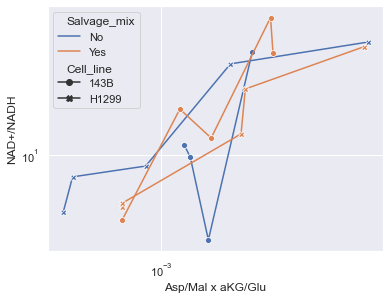

In [23]:
### NAD+/NADH ratio as a function of Asp/Mal x aKG/Glu  ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp-Mal-aKG-Glu_vs_NAD-NADH_143B-H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
mask2 = (df_mean['Cell_line']=='143B') & \
       (((df_mean['Metformin'] < 1.3) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 1.1) & (df_mean['Salvage_mix'] == 'No')))
mask3 = mask1 | mask2

g = sns.lineplot(data=df_mean[mask3], y='NAD-NADH', x='Asp-Mal-aKG-Glu', hue='Salvage_mix',
             style='Cell_line', markers=True, dashes=False)

#g.errorbar(x=df_mean[mask3]['Asp-Mal-aKG-Glu'].values, y=df_mean[mask3]['NAD-NADH'].values, xerr=df_stdev[mask3]['Asp-Mal-aKG-Glu'].values, yerr=df_stdev[mask3]['NAD-NADH'].values, fmt='none', color='black', capsize=5)

g.set(xscale="log");
g.set(yscale="log");

plt.ylabel('NAD+/NADH', size=12);
plt.xlabel('Asp/Mal x aKG/Glu', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

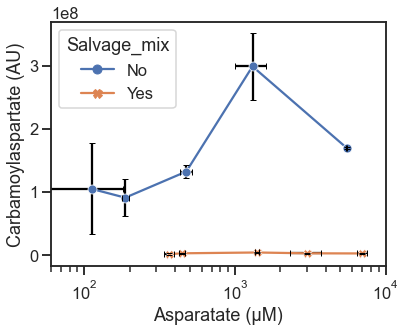

In [483]:
### Carbamoylaspartate as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Carbamoyl-Asp_H1299_err.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], y='Carbamoylaspartate neg', x='Aspartate conc', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

g.errorbar(y=df_mean[mask1]['Carbamoylaspartate neg'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['Carbamoylaspartate neg'].values, fmt='none', color='black', capsize=3)

g.set(xscale="log");
g.set(xlim=(60, 10000))
#g.set(ylim=(0, 330))


plt.ylabel('Carbamoylaspartate (AU)')#, size=12);
plt.xlabel('Asparatate (μM)')#, size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

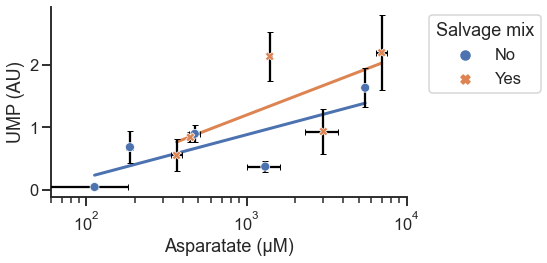

In [514]:
### UMP as a function of Aspartate ###
pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_UMP_H1299.pdf")
fig = plt.figure(figsize=(8, 4))

mask = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
g = sns.scatterplot(data=df_mean[mask], y='UMP neg', x='Aspartate conc', hue='Salvage_mix',
             style='Salvage_mix', markers=True, zorder=11, s=80)
g.errorbar(y=df_mean[mask]['UMP neg'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', yerr=df_stdev[mask]['UMP neg'].values, color='black', capsize=3, zorder=10)
#g.set(yscale="log");
g.set(xscale="log");

#g.set(ylim=(0.3, 20))
g.set(xlim=(60, 10000))

if False:
    plt.grid(True, which="both", ls="--", c='gray', linewidth=0.5)
    locmin = mticker.LogLocator(base=10, subs=np.arange(0.1,1,0.1), numticks=10)  
    g.yaxis.set_minor_locator(locmin)
    g.yaxis.set_minor_formatter(mticker.NullFormatter())
else:
    plt.grid(False)
    

plt.ylabel('UMP (AU)')#, size=12);
plt.xlabel('Asparatate (μM)')#, size=12);


if True:
    ### Fit regression ###
    x_no = np.array([np.log10(x) for x, b in zip(df_mean[mask]['Aspartate conc'], df_mean[mask]['Salvage_mix']) if b == 'No' ])
    y_no = np.array([y for y, b in zip(df_mean[mask]['UMP neg'], df_mean[mask]['Salvage_mix']) if b == 'No' ])

    x_yes = np.array([np.log10(x) for x, b in zip(df_mean[mask]['Aspartate conc'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])
    y_yes = np.array([y for y, b in zip(df_mean[mask]['UMP neg'], df_mean[mask]['Salvage_mix']) if b == 'Yes' ])

    b_no, m_no = polyfit(x_no, y_no, 1)
    b_yes, m_yes = polyfit(x_yes, y_yes, 1)

    plt.plot(10**x_no, (b_no + m_no * x_no), '-', linewidth=3)
    plt.plot(10**x_yes, (b_yes + m_yes * x_yes), '-', linewidth=3)

    ######################

sns.despine()


plt.legend(bbox_to_anchor=(1.04,1), loc="upper left", title='Salvage mix')
plt.tight_layout()

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

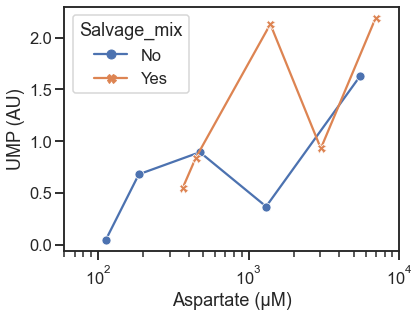

In [513]:
### UMP as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_UMP_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)# & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], y='UMP neg', x='Aspartate conc', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

#g.errorbar(y=df_mean[mask1]['UMP neg'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, yerr=df_stdev[mask1]['UMP neg'].values, fmt='none', color='black', capsize=5)

g.set(xscale="log");
g.set(xlim=(60, 10000))

plt.ylabel('UMP (AU)')#, size=12);
plt.xlabel('Aspartate (μM)')#', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

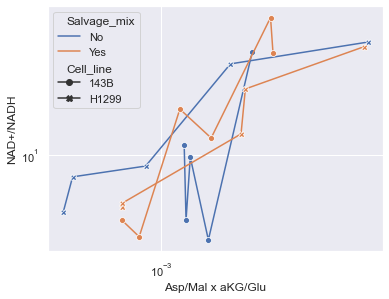

In [26]:
### Proliferation rate as a function of NAD+/NADH ratio ###

#pdf = matplotlib.backends.backend_pdf.PdfPages("NAD-NADH_vs_Proliferation_H1299.pdf")
fig = plt.figure(figsize=(6, 4.5))
# mask1 = (df_mean['Cell_line']=='H1299') & (df_mean['Metformin'] < 14)
mask1 = (df_mean['Metformin'] < 14)
g = sns.lineplot(data=df_mean[mask1], y='NAD-NADH', x='Asp-Mal-aKG-Glu', hue='Salvage_mix',
             style='Cell_line', markers=True, dashes=False)

#g.errorbar(x=df_mean[mask1]['Asp-Mal-aKG-Glu'].values, y=df_mean[mask1]['NAD-NADH'].values, xerr=df_stdev[mask1]['Asp-Mal-aKG-Glu'].values, yerr=df_stdev[mask1]['NAD-NADH'].values, fmt='none', color='black', capsize=5)

g.set(xscale="log");
g.set(yscale="log");

plt.ylabel('NAD+/NADH', size=12);
plt.xlabel('Asp/Mal x aKG/Glu', size=12);

#pdf.savefig(fig)
#plt.show(fig)
#plt.close(fig)
#pdf.close()

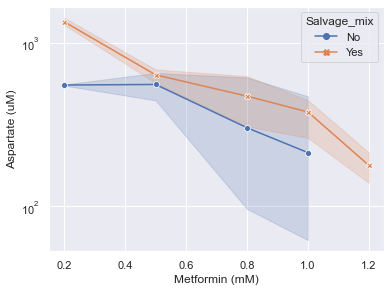

In [27]:
### Aspartate as a function of Metformin ###

pdf = matplotlib.backends.backend_pdf.PdfPages("metformin_vs_Asp_143B.pdf")
fig = plt.figure(figsize=(6, 4.5))

mask = (df['Cell_line']=='143B') & \
       (((df['Metformin'] < 1.3) & (df['Salvage_mix'] == 'Yes')) | \
        ((df['Metformin'] < 1.1) & (df['Salvage_mix'] == 'No')))
g = sns.lineplot(data=df[mask], x='Metformin', y='Aspartate conc', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)
g.set(yscale="log");

plt.xlabel('Metformin (mM)', size=12);
plt.ylabel('Aspartate (μM)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

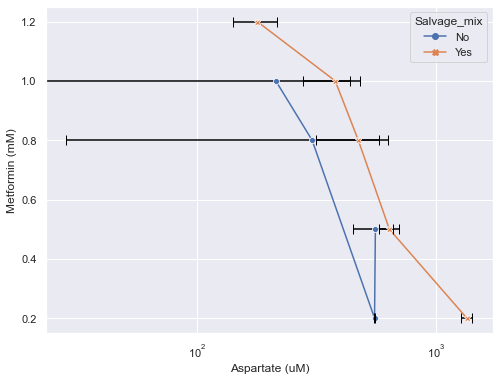

In [28]:
### Metformin as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Met_143B.pdf")
fig = plt.figure(figsize=(8, 6))
mask = (df_mean['Cell_line']=='143B') & \
       (((df_mean['Metformin'] < 1.3) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 1.1) & (df_mean['Salvage_mix'] == 'No')))
g = sns.lineplot(data=df_mean[mask], x='Aspartate conc', y='Metformin', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)
g.errorbar(y=df_mean[mask]['Metformin'].values, x=df_mean[mask]['Aspartate conc'].values, xerr=df_stdev[mask]['Aspartate conc'].values, fmt='none', color='black', capsize=5)
#g.set(yscale="log");
g.set(xscale="log");


plt.ylabel('Metformin (mM)', size=12);
plt.xlabel('Aspartate (μM)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

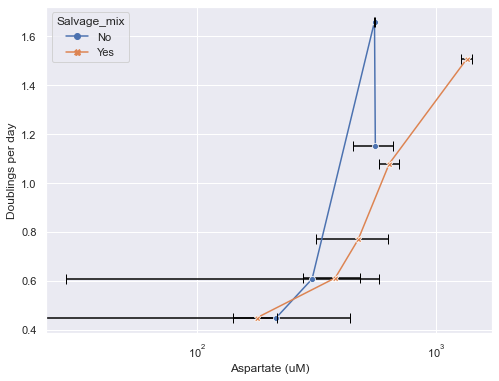

In [29]:
### Proliferation rate as a function of Aspartate ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp_vs_Proliferation_143B.pdf")
fig = plt.figure(figsize=(8, 6))
mask1 = (df_mean['Cell_line']=='143B') & \
       (((df_mean['Metformin'] < 1.3) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 1.1) & (df_mean['Salvage_mix'] == 'No')))
g = sns.lineplot(data=df_mean[mask1], x='Aspartate conc', y='Proliferation_rate', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)
g.errorbar(y=df_mean[mask1]['Proliferation_rate'].values, x=df_mean[mask1]['Aspartate conc'].values, xerr=df_stdev[mask1]['Aspartate conc'].values, fmt='none', color='black', capsize=5)

mask2 = (df['Cell_line']=='H1299') & (df['Metformin'] < 14)
g.set(xscale="log");


plt.ylabel('Doublings per day', size=12);
plt.xlabel('Aspartate (μM)', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

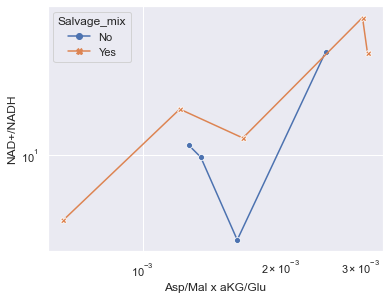

In [30]:
### NAD+/NADH ratio as a function of Asp/Mal x aKG/Glu  ###

pdf = matplotlib.backends.backend_pdf.PdfPages("Asp-Mal-aKG-Glu_vs_NAD-NADH_143B.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='143B') & \
       (((df_mean['Metformin'] < 1.3) & (df_mean['Salvage_mix'] == 'Yes')) | \
        ((df_mean['Metformin'] < 1.1) & (df_mean['Salvage_mix'] == 'No')))
g = sns.lineplot(data=df_mean[mask1], y='NAD-NADH', x='Asp-Mal-aKG-Glu', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

#g.errorbar(x=df_mean[mask1]['Asp-Mal-aKG-Glu'].values, y=df_mean[mask1]['NAD-NADH'].values, xerr=df_stdev[mask1]['Asp-Mal-aKG-Glu'].values, yerr=df_stdev[mask1]['NAD-NADH'].values, fmt='none', color='black', capsize=5)

g.set(xscale="log");
g.set(yscale="log");

plt.ylabel('NAD+/NADH', size=12);
plt.xlabel('Asp/Mal x aKG/Glu', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()

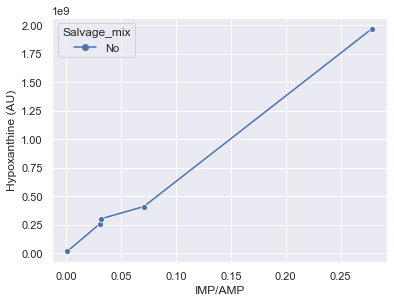

In [31]:
### Hypoxanthine as a function of IMP/AMP ratio ###

pdf = matplotlib.backends.backend_pdf.PdfPages("IMP-AMP_vs_Hypoxanthine_143B.pdf")
fig = plt.figure(figsize=(6, 4.5))
mask1 = (df_mean['Cell_line']=='143B') & (df_mean['Metformin'] < 14) & (df_mean['Salvage_mix'] == 'No')
g = sns.lineplot(data=df_mean[mask1], x='IMP-AMP', y='Hypoxanthine pos', hue='Salvage_mix',
             style='Salvage_mix', markers=True, dashes=False)

#g.errorbar(y=df_mean[mask1]['Hypoxanthine pos'].values, x=df_mean[mask1]['IMP-AMP'].values, xerr=df_stdev[mask1]['IMP-AMP'].values, yerr=df_stdev[mask1]['Hypoxanthine pos'].values, fmt='none', color='black', capsize=5)


plt.ylabel('Hypoxanthine (AU)', size=12);
plt.xlabel('IMP/AMP', size=12);

pdf.savefig(fig)
plt.show(fig)
plt.close(fig)
pdf.close()